<a href="https://colab.research.google.com/github/yeticheese/NMA_2024_Zealous_Sedum_CN/blob/main/notebooksoad_Allen_Visual_Behavior_from_SDK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
This notebook shows how to access and interact with 2-photon calcium imaging data collected as part of the Allen Institute's Visual Behavior 2P project.

You can learn more about this dataset, behavioral task, and find other useful tools here:
[Overview page](https://allenswdb.github.io/physiology/ophys/visual-behavior/VB-Ophys.html) and [Allen Brain Atlas](allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html)

Specifically, this notebook will show how to load neural data for all imaging planes in one 2-photon imaging session into a single 'tidy' dataframe, make  simple event-triggered plots, and do some basic analysis using scikit-learn.

This is designed to demonstrate a simple method for interacting with the Visual Behavior 2P data. Many aspects of the dataset are not explored here.

# Set up environment and import packages

We have built a package called `brain_observatory_utilities` which contains some useful convenience functions. The `allenSDK` is a dependency of this package and will be automatically installed when you install `brain_observatory_utilities` per the instrutions below.

We will first install `brain_observatory_utilities` into our colab environment by running the commands below. When this cell is complete, click on the `RESTART RUNTIME` button that appears at the end of the output. Note that running this cell will produce a long list of outputs and some error messages. Clicking `RESTART RUNTIME` at the end will resolve these issues.

You can minimize the cell after you are done to hide the output.

In [ ]:
# @title Install packages
!pip install pip --upgrade --quiet
!pip install brain_observatory_utilities --upgrade --quiet
!pip install pandas --quiet
!pip install seaborn --quiet

#### Next we will import packages we need later in the notebook

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as ophys_formatting
import brain_observatory_utilities.utilities.general_utilities as utilities

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)
# this line may be needed if you run into Error in pandas query function
# Otherwise set the engine to python in queries made throught the book
# pd.DataFrame.query = lambda self, expr, **kwargs: self.query(expr, engine='python', **kwargs)

# Load the session and experiment summary tables

The AllenSDK provides functionality for downloading tables that describe all sessions and experiments (individual imaging planes) in the Visual Behavior 2P dataset. We first download the data cache:

In [ ]:
data_storage_directory = "./temp"  # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv:   0%|          | 0.00/247k [00:00<?, ?MB/s]

ophys_session_table.csv:   0%|          | 1.02k/247k [00:00<00:24, 10.1kMB/s]

ophys_session_table.csv: 100%|██████████| 247k/247k [00:00<00:00, 2.32MMB/s] 

behavior_session_table.csv:   0%|          | 0.00/1.59M [00:00<?, ?MB/s]

behavior_session_table.csv:   0%|          | 1.02k/1.59M [00:00<04:22, 6.06kMB/s]

behavior_session_table.csv:  38%|███▊      | 609k/1.59M [00:00<00:00, 2.52MMB/s] 

behavior_session_table.csv:  82%|████████▏ | 1.31M/1.59M [00:00<00:00, 3.53MMB/s]

behavior_session_table.csv: 100%|██████████| 1.59M/1.59M [00:00<00:00, 3.54MMB/s]

ophys_experiment_table.csv:   0%|          | 0.00/657k [00:00<?, ?MB/s]

ophys_experiment_table.csv:   0%|          | 1.02k/657k [00:00<01:31, 7.18kMB/s]

ophys_experiment_table.csv: 100%|██████████| 657k/657k [00:00<00:00, 3.22MMB/s] 

ophys_cells_table.csv:   0%|          | 0.00/4.28M [00:00<?, ?MB/s]

ophys_cells_table.csv:   0%|          | 1.02k/4.28M [00:00<10:15, 6.96kMB/s]

ophys_cells_table.csv:  20%|█▉        | 837k/4.28M [00:00<00:00, 3.80MMB/s] 

ophys_cells_table.csv:  42%|████▏     | 1.78M/4.28M [00:00<00:00, 5.69MMB/s]

ophys_cells_table.csv:  66%|██████▌   | 2.83M/4.28M [00:00<00:00, 6.20MMB/s]

ophys_cells_table.csv:  93%|█████████▎| 3.99M/4.28M [00:00<00:00, 7.08MMB/s]

ophys_cells_table.csv: 100%|██████████| 4.28M/4.28M [00:00<00:00, 6.32MMB/s]

/opt/hostedtoolcache/Python/3.9.19/x64/lib/python3.9/site-packages/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


- `Ophys_session_table` contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple ophys experiment ids. Each ophys session id will also have a unique behavior session id.
- `Behavior_session_table` contains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have ophys session ids were training sessions.
- `Ophys_experiment_table` contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique experiment ids. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the `ophys_container_id` column that can be found in both `ophys_session_table` and `ophys_experiment_table`.

Then we can access the session and experiment tables directly.

Note that a 'session' is a single behavioral session. Sessions that are performed on the mesoscope will have multiple (up to 8) 'experiments' associated with them, where an experiment is a distinct imaging plane.

In [ ]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

We can then view the contents of the session table. Note that this contains a lot of useful metadata about each session. One of the columns, `ophys_experiment_id` provides a list of the experiments (aka imaging planes) that are associated with each session.

In [ ]:
session_table.head()

behavior_session_id  \
ophys_session_id                        
951410079                   951520319   
952430817                   952554548   
954954402                   953982960   
955775716                   956010809   
957020350                   957032492   

                                                 ophys_container_id mouse_id  \
ophys_session_id                                                               
951410079         [1018028339, 1018028342, 1018028345, 101802835...   457841   
952430817          [1018028339, 1018028345, 1018028354, 1018028357]   457841   
954954402         [1018028339, 1018028342, 1018028345, 101802835...   457841   
955775716                      [1018028339, 1018028342, 1018028345]   457841   
957020350         [1018028339, 1018028342, 1018028345, 101802835...   457841   

                 indicator                                  full_genotype  \
ophys_session_id                                                            
951410079          GCaMP6f  Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
952430817          GCaMP6f  Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
954954402          GCaMP6f  Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
955775716          GCaMP6f  Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
957020350          GCaMP6f  Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   

                     driver_line      cre_line               reporter_line  \
ophys_session_id                                                             
951410079         [Sst-IRES-Cre]  Sst-IRES-Cre  Ai148(TIT2L-GC6f-ICL-tTA2)   
952430817         [Sst-IRES-Cre]  Sst-IRES-Cre  Ai148(TIT2L-GC6f-ICL-tTA2)   
954954402         [Sst-IRES-Cre]  Sst-IRES-Cre  Ai148(TIT2L-GC6f-ICL-tTA2)   
955775716         [Sst-IRES-Cre]  Sst-IRES-Cre  Ai148(TIT2L-GC6f-ICL-tTA2)   
957020350         [Sst-IRES-Cre]  Sst-IRES-Cre  Ai148(TIT2L-GC6f-ICL-tTA2)   

                 sex  age_in_days  imaging_plane_group_count  \
ophys_session_id                                               
951410079          F          206                          4   
952430817          F          209                          3   
954954402          F          210                          4   
955775716          F          212                          2   
957020350          F          213                          4   

                              project_code              session_type  \
ophys_session_id                                                       
951410079         VisualBehaviorMultiscope          OPHYS_1_images_A   
952430817         VisualBehaviorMultiscope  OPHYS_2_images_A_passive   
954954402         VisualBehaviorMultiscope          OPHYS_3_images_A   
955775716         VisualBehaviorMultiscope          OPHYS_3_images_A   
957020350         VisualBehaviorMultiscope          OPHYS_4_images_B   

                  session_number image_set    behavior_type experience_level  \
ophys_session_id                                                               
951410079                      1  images_A  active_behavior         Familiar   
952430817                      2  images_A  passive_viewing         Familiar   
954954402                      3  images_A  active_behavior         Familiar   
955775716                      3  images_A  active_behavior         Familiar   
957020350                      4  images_B  active_behavior          Novel 1   

                  prior_exposures_to_session_type  \
ophys_session_id                                    
951410079                                       0   
952430817                                       0   
954954402                                       0   
955775716                                       1   
957020350                                       0   

                  prior_exposures_to_image_set  prior_exposures_to_omissions  \
ophys_session_id                                                               
951410079                          

The experiment table has one row per experiment. Note that the `ophys_session_id` column links each experiment to its associated session in the session_table.

In [ ]:
experiment_table.head()

behavior_session_id  ophys_session_id  \
ophys_experiment_id                                          
951980471                      951520319         951410079   
951980473                      951520319         951410079   
951980475                      951520319         951410079   
951980479                      951520319         951410079   
951980481                      951520319         951410079   

                     ophys_container_id mouse_id indicator  \
ophys_experiment_id                                          
951980471                    1018028342   457841   GCaMP6f   
951980473                    1018028345   457841   GCaMP6f   
951980475                    1018028339   457841   GCaMP6f   
951980479                    1018028354   457841   GCaMP6f   
951980481                    1018028357   457841   GCaMP6f   

                                                     full_genotype  \
ophys_experiment_id                                                  
951980471            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
951980473            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
951980475            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
951980479            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   
951980481            Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt   

                        driver_line      cre_line               reporter_line  \
ophys_experiment_id                                                             
951980471            [Sst-IRES-Cre]  Sst-IRES-Cre  Ai148(TIT2L-GC6f-ICL-tTA2)   
951980473            [Sst-IRES-Cre]  Sst-IRES-Cre  Ai148(TIT2L-GC6f-ICL-tTA2)   
951980475            [Sst-IRES-Cre]  Sst-IRES-Cre  Ai148(TIT2L-GC6f-ICL-tTA2)   
951980479            [Sst-IRES-Cre]  Sst-IRES-Cre  Ai148(TIT2L-GC6f-ICL-tTA2)   
951980481            [Sst-IRES-Cre]  Sst-IRES-Cre  Ai148(TIT2L-GC6f-ICL-tTA2)   

                    sex  age_in_days  imaging_depth targeted_structure  \
ophys_experiment_id                                                      
951980471             F          206            150               VISp   
951980473             F          206            225               VISp   
951980475             F          206             75               VISp   
951980479             F          206            150               VISl   
951980481             F          206            225               VISl   

                     targeted_imaging_depth  imaging_plane_group  \
ophys_experiment_id                                                
951980471                               150                    0   
951980473                               225                    0   
951980475                                75                    1   
951980479                               150                    2   
951980481                               225                    2   

                                 project_code      session_type  \
ophys_experiment_id                                               
951980471            VisualBehaviorMultiscope  OPHYS_1_images_A   
951980473            VisualBehaviorMultiscope  OPHYS_1_images_A   
951980475            VisualBehaviorMultiscope  OPHYS_1_images_A   
951980479            VisualBehaviorMultiscope  OPHYS_1_images_A   
951980481            VisualBehaviorMultiscope  OPHYS_1_images_A   

                     session_number image_set    behavior_type  passive  \
ophys_experiment_id                                                       
951980471                         1         A  active_behavior    False   
951980473                         1         A  active_behavior    False   
951980475                         1         A  active_behavior    False   
951980479                         1         A  active_behavior    False   
951980481                         1         A  active_behavior    False   

                    experience_level  prior_exposures_to_session_type  \
ophys_experiment_id        

# Load one example session
We are going to select one session from this table, session 854060305. This is a session with Sst-IRES-Cre mouse, which expressed GCaMP6f in Sst+ inhibitory interneurons. There were 6 simultaneously acquired imaging planes for this session.
We can view metadata for this session as follows:

In [ ]:
ophys_session_id = 854060305
session_table.loc[ophys_session_id]

behavior_session_id                                                        854283407
ophys_container_id                 [1018028135, 1018028138, 1018028141, 101802814...
mouse_id                                                                      440631
indicator                                                                    GCaMP6f
full_genotype                          Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
driver_line                                                           [Sst-IRES-Cre]
cre_line                                                                Sst-IRES-Cre
reporter_line                                             Ai148(TIT2L-GC6f-ICL-tTA2)
sex                                                                                M
age_in_days                                                                      129
imaging_plane_group_count                                                          3
project_code                                                Visua

# Download all associated experiments

Each session consists of one or more 'experiments', in which each experiment is a single imaging plane

Each mesoscope session has up to 8 experiments associated with the session. We will load all sessions into a dictionary with the experiment IDs as the keys

The first time that this cell is run, the associated NWB files will be downloaded to your local `data_storage_directory`. Subsequent runs of this cell will be faster since the data will already be cached locally.

In [ ]:
experiments = {}
ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

behavior_ophys_experiment_854759890.nwb:   0%|          | 0.00/232M [00:00<?, ?MB/s]

behavior_ophys_experiment_854759890.nwb:   0%|          | 1.02k/232M [00:00<15:15:42, 4.22kMB/s]

behavior_ophys_experiment_854759890.nwb:   1%|          | 1.30M/232M [00:00<00:53, 4.29MMB/s]   

behavior_ophys_experiment_854759890.nwb:   1%|          | 2.73M/232M [00:00<00:31, 7.20MMB/s]

behavior_ophys_experiment_854759890.nwb:   2%|▏         | 4.30M/232M [00:00<00:24, 9.41MMB/s]

behavior_ophys_experiment_854759890.nwb:   3%|▎         | 6.06M/232M [00:00<00:19, 11.3MMB/s]

behavior_ophys_experiment_854759890.nwb:   3%|▎         | 7.97M/232M [00:00<00:17, 13.1MMB/s]

behavior_ophys_experiment_854759890.nwb:   4%|▍         | 10.1M/232M [00:00<00:14, 14.8MMB/s]

behavior_ophys_experiment_854759890.nwb:   5%|▌         | 12.4M/232M [00:01<00:13, 16.6MMB/s]

behavior_ophys_experiment_854759890.nwb:   6%|▋         | 15.0M/232M [00:01<00:11, 18.5MMB/s]

behavior_ophys_experiment_854759890.nwb:   8%|▊         | 17.9M/232M [00:01<00:11, 19.1MMB/s]

behavior_ophys_experiment_854759890.nwb:   9%|▉         | 21.0M/232M [00:01<00:09, 21.1MMB/s]

behavior_ophys_experiment_854759890.nwb:  11%|█         | 24.5M/232M [00:01<00:08, 23.8MMB/s]

behavior_ophys_experiment_854759890.nwb:  12%|█▏        | 28.3M/232M [00:01<00:07, 26.6MMB/s]

behavior_ophys_experiment_854759890.nwb:  14%|█▍        | 32.5M/232M [00:01<00:06, 29.6MMB/s]

behavior_ophys_experiment_854759890.nwb:  16%|█▌        | 37.1M/232M [00:01<00:05, 33.5MMB/s]

behavior_ophys_experiment_854759890.nwb:  18%|█▊        | 42.1M/232M [00:02<00:05, 34.9MMB/s]

behavior_ophys_experiment_854759890.nwb:  20%|██        | 47.4M/232M [00:02<00:05, 36.8MMB/s]

behavior_ophys_experiment_854759890.nwb:  22%|██▏       | 51.9M/232M [00:02<00:04, 37.6MMB/s]

behavior_ophys_experiment_854759890.nwb:  24%|██▍       | 56.3M/232M [00:02<00:04, 39.3MMB/s]

behavior_ophys_experiment_854759890.nwb:  26%|██▋       | 61.1M/232M [00:02<00:04, 41.8MMB/s]

behavior_ophys_experiment_854759890.nwb:  28%|██▊       | 65.8M/232M [00:02<00:03, 42.8MMB/s]

behavior_ophys_experiment_854759890.nwb:  31%|███       | 71.3M/232M [00:02<00:03, 46.1MMB/s]

behavior_ophys_experiment_854759890.nwb:  33%|███▎      | 76.4M/232M [00:02<00:03, 42.1MMB/s]

behavior_ophys_experiment_854759890.nwb:  35%|███▌      | 82.1M/232M [00:02<00:03, 46.1MMB/s]

behavior_ophys_experiment_854759890.nwb:  37%|███▋      | 86.9M/232M [00:03<00:03, 45.1MMB/s]

behavior_ophys_experiment_854759890.nwb:  39%|███▉      | 91.4M/232M [00:03<00:04, 31.7MMB/s]

behavior_ophys_experiment_854759890.nwb:  41%|████      | 95.2M/232M [00:03<00:04, 28.2MMB/s]

behavior_ophys_experiment_854759890.nwb:  43%|████▎     | 98.9M/232M [00:03<00:04, 29.5MMB/s]

behavior_ophys_experiment_854759890.nwb:  44%|████▍     | 102M/232M [00:03<00:04, 30.6MMB/s] 

behavior_ophys_experiment_854759890.nwb:  46%|████▌     | 106M/232M [00:03<00:04, 31.1MMB/s]

behavior_ophys_experiment_854759890.nwb:  47%|████▋     | 109M/232M [00:03<00:04, 26.4MMB/s]

behavior_ophys_experiment_854759890.nwb:  49%|████▉     | 113M/232M [00:04<00:04, 29.4MMB/s]

behavior_ophys_experiment_854759890.nwb:  50%|█████     | 117M/232M [00:04<00:04, 23.9MMB/s]

behavior_ophys_experiment_854759890.nwb:  51%|█████▏    | 119M/232M [00:04<00:04, 23.4MMB/s]

behavior_ophys_experiment_854759890.nwb:  53%|█████▎    | 124M/232M [00:04<00:03, 28.8MMB/s]

behavior_ophys_experiment_854759890.nwb:  55%|█████▍    | 127M/232M [00:04<00:04, 23.3MMB/s]

behavior_ophys_experiment_854759890.nwb:  56%|█████▋    | 131M/232M [00:04<00:03, 25.9MMB/s]

behavior_ophys_experiment_854759890.nwb:  58%|█████▊    | 134M/232M [00:04<00:04, 23.9MMB/s]

behavior_ophys_experiment_854759890.nwb:  60%|█████▉    | 139M/232M [00:05<00:03, 27.6MMB/s]

behavior_ophys_experiment_854759890.nwb:  62%|██████▏   | 143M/232M [00:05<00:03, 25.7MMB/s]

behavior_ophys_experiment_854759890.nwb:  63%|██████▎   | 146M/232M [00:05<00:03, 27.5MMB/s]

behavior_ophys_experiment_854759890.nwb:  65%|██████▍   | 150M/232M [00:05<00:02, 31.6MMB/s]

behavior_ophys_experiment_854759890.nwb:  66%|██████▋   | 154M/232M [00:05<00:02, 26.7MMB/s]

behavior_ophys_experiment_854759890.nwb:  68%|██████▊   | 158M/232M [00:05<00:02, 29.0MMB/s]

behavior_ophys_experiment_854759890.nwb:  69%|██████▉   | 161M/232M [00:05<00:02, 28.1MMB/s]

behavior_ophys_experiment_854759890.nwb:  71%|███████   | 164M/232M [00:05<00:02, 28.7MMB/s]

behavior_ophys_experiment_854759890.nwb:  73%|███████▎  | 168M/232M [00:06<00:02, 31.1MMB/s]

behavior_ophys_experiment_854759890.nwb:  74%|███████▍  | 171M/232M [00:06<00:01, 30.4MMB/s]

behavior_ophys_experiment_854759890.nwb:  75%|███████▌  | 175M/232M [00:06<00:02, 23.0MMB/s]

behavior_ophys_experiment_854759890.nwb:  77%|███████▋  | 178M/232M [00:06<00:02, 24.4MMB/s]

behavior_ophys_experiment_854759890.nwb:  78%|███████▊  | 181M/232M [00:06<00:01, 27.1MMB/s]

behavior_ophys_experiment_854759890.nwb:  80%|███████▉  | 185M/232M [00:06<00:01, 23.8MMB/s]

behavior_ophys_experiment_854759890.nwb:  82%|████████▏ | 189M/232M [00:06<00:01, 27.8MMB/s]

behavior_ophys_experiment_854759890.nwb:  83%|████████▎ | 193M/232M [00:07<00:01, 27.6MMB/s]

behavior_ophys_experiment_854759890.nwb:  85%|████████▍ | 196M/232M [00:07<00:01, 27.9MMB/s]

behavior_ophys_experiment_854759890.nwb:  86%|████████▋ | 200M/232M [00:07<00:01, 28.6MMB/s]

behavior_ophys_experiment_854759890.nwb:  88%|████████▊ | 205M/232M [00:07<00:00, 32.4MMB/s]

behavior_ophys_experiment_854759890.nwb:  90%|████████▉ | 208M/232M [00:07<00:00, 29.0MMB/s]

behavior_ophys_experiment_854759890.nwb:  91%|█████████ | 211M/232M [00:07<00:01, 19.7MMB/s]

behavior_ophys_experiment_854759890.nwb:  93%|█████████▎| 215M/232M [00:07<00:00, 22.6MMB/s]

behavior_ophys_experiment_854759890.nwb:  94%|█████████▍| 217M/232M [00:08<00:00, 23.3MMB/s]

behavior_ophys_experiment_854759890.nwb:  95%|█████████▌| 220M/232M [00:08<00:00, 20.4MMB/s]

behavior_ophys_experiment_854759890.nwb:  96%|█████████▌| 222M/232M [00:08<00:00, 20.6MMB/s]

behavior_ophys_experiment_854759890.nwb:  98%|█████████▊| 226M/232M [00:08<00:00, 22.7MMB/s]

behavior_ophys_experiment_854759890.nwb: 100%|█████████▉| 231M/232M [00:08<00:00, 24.4MMB/s]

behavior_ophys_experiment_854759890.nwb: 100%|██████████| 232M/232M [00:08<00:00, 25.8MMB/s]


/opt/hostedtoolcache/Python/3.9.19/x64/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


behavior_ophys_experiment_854759894.nwb:   0%|          | 0.00/252M [00:00<?, ?MB/s]

behavior_ophys_experiment_854759894.nwb:   0%|          | 1.02k/252M [00:00<13:25:43, 5.21kMB/s]

behavior_ophys_experiment_854759894.nwb:   0%|          | 60.4k/252M [00:00<17:56, 234kMB/s]    

behavior_ophys_experiment_854759894.nwb:   0%|          | 287k/252M [00:00<04:41, 894kMB/s] 

behavior_ophys_experiment_854759894.nwb:   0%|          | 1.03M/252M [00:00<01:29, 2.81MMB/s]

behavior_ophys_experiment_854759894.nwb:   2%|▏         | 4.21M/252M [00:00<00:22, 10.8MMB/s]

behavior_ophys_experiment_854759894.nwb:   3%|▎         | 8.49M/252M [00:00<00:13, 18.1MMB/s]

behavior_ophys_experiment_854759894.nwb:   5%|▌         | 12.7M/252M [00:00<00:10, 23.5MMB/s]

behavior_ophys_experiment_854759894.nwb:   7%|▋         | 17.0M/252M [00:01<00:08, 27.2MMB/s]

behavior_ophys_experiment_854759894.nwb:   8%|▊         | 21.3M/252M [00:01<00:07, 29.1MMB/s]

behavior_ophys_experiment_854759894.nwb:  10%|█         | 26.4M/252M [00:01<00:06, 32.9MMB/s]

behavior_ophys_experiment_854759894.nwb:  12%|█▏        | 30.8M/252M [00:01<00:06, 35.8MMB/s]

behavior_ophys_experiment_854759894.nwb:  14%|█▎        | 34.5M/252M [00:01<00:06, 35.5MMB/s]

behavior_ophys_experiment_854759894.nwb:  16%|█▌        | 39.3M/252M [00:01<00:05, 37.2MMB/s]

behavior_ophys_experiment_854759894.nwb:  18%|█▊        | 44.7M/252M [00:01<00:05, 39.6MMB/s]

behavior_ophys_experiment_854759894.nwb:  20%|█▉        | 50.1M/252M [00:01<00:04, 41.3MMB/s]

behavior_ophys_experiment_854759894.nwb:  22%|██▏       | 55.0M/252M [00:01<00:04, 43.4MMB/s]

behavior_ophys_experiment_854759894.nwb:  24%|██▎       | 59.4M/252M [00:02<00:04, 42.1MMB/s]

behavior_ophys_experiment_854759894.nwb:  25%|██▌       | 63.6M/252M [00:02<00:04, 38.6MMB/s]

behavior_ophys_experiment_854759894.nwb:  27%|██▋       | 68.5M/252M [00:02<00:04, 41.2MMB/s]

behavior_ophys_experiment_854759894.nwb:  29%|██▉       | 73.4M/252M [00:02<00:04, 43.5MMB/s]

behavior_ophys_experiment_854759894.nwb:  31%|███       | 77.8M/252M [00:02<00:04, 36.9MMB/s]

behavior_ophys_experiment_854759894.nwb:  32%|███▏      | 81.7M/252M [00:02<00:04, 36.9MMB/s]

behavior_ophys_experiment_854759894.nwb:  34%|███▍      | 85.6M/252M [00:02<00:05, 32.6MMB/s]

behavior_ophys_experiment_854759894.nwb:  35%|███▌      | 89.0M/252M [00:02<00:05, 32.4MMB/s]

behavior_ophys_experiment_854759894.nwb:  37%|███▋      | 92.4M/252M [00:03<00:04, 32.6MMB/s]

behavior_ophys_experiment_854759894.nwb:  39%|███▊      | 97.3M/252M [00:03<00:04, 33.2MMB/s]

behavior_ophys_experiment_854759894.nwb:  41%|████      | 103M/252M [00:03<00:04, 36.1MMB/s] 

behavior_ophys_experiment_854759894.nwb:  43%|████▎     | 108M/252M [00:03<00:03, 38.5MMB/s]

behavior_ophys_experiment_854759894.nwb:  45%|████▍     | 113M/252M [00:03<00:03, 41.0MMB/s]

behavior_ophys_experiment_854759894.nwb:  46%|████▋     | 117M/252M [00:03<00:04, 33.1MMB/s]

behavior_ophys_experiment_854759894.nwb:  48%|████▊     | 120M/252M [00:03<00:05, 26.1MMB/s]

behavior_ophys_experiment_854759894.nwb:  49%|████▉     | 124M/252M [00:04<00:04, 27.5MMB/s]

behavior_ophys_experiment_854759894.nwb:  51%|█████     | 127M/252M [00:04<00:04, 27.0MMB/s]

behavior_ophys_experiment_854759894.nwb:  52%|█████▏    | 132M/252M [00:04<00:03, 31.0MMB/s]

behavior_ophys_experiment_854759894.nwb:  54%|█████▎    | 135M/252M [00:04<00:05, 23.0MMB/s]

behavior_ophys_experiment_854759894.nwb:  55%|█████▌    | 139M/252M [00:04<00:04, 26.3MMB/s]

behavior_ophys_experiment_854759894.nwb:  57%|█████▋    | 142M/252M [00:04<00:04, 25.6MMB/s]

behavior_ophys_experiment_854759894.nwb:  58%|█████▊    | 145M/252M [00:04<00:05, 20.4MMB/s]

behavior_ophys_experiment_854759894.nwb:  59%|█████▉    | 149M/252M [00:05<00:04, 23.9MMB/s]

behavior_ophys_experiment_854759894.nwb:  61%|██████    | 152M/252M [00:05<00:03, 25.2MMB/s]

behavior_ophys_experiment_854759894.nwb:  62%|██████▏   | 156M/252M [00:05<00:03, 27.3MMB/s]

behavior_ophys_experiment_854759894.nwb:  63%|██████▎   | 159M/252M [00:05<00:03, 23.2MMB/s]

behavior_ophys_experiment_854759894.nwb:  65%|██████▌   | 164M/252M [00:05<00:03, 26.7MMB/s]

behavior_ophys_experiment_854759894.nwb:  67%|██████▋   | 168M/252M [00:05<00:03, 21.1MMB/s]

behavior_ophys_experiment_854759894.nwb:  68%|██████▊   | 172M/252M [00:06<00:03, 24.4MMB/s]

behavior_ophys_experiment_854759894.nwb:  70%|██████▉   | 175M/252M [00:06<00:03, 23.0MMB/s]

behavior_ophys_experiment_854759894.nwb:  71%|███████   | 177M/252M [00:06<00:03, 21.9MMB/s]

behavior_ophys_experiment_854759894.nwb:  72%|███████▏  | 181M/252M [00:06<00:02, 24.4MMB/s]

behavior_ophys_experiment_854759894.nwb:  73%|███████▎  | 184M/252M [00:06<00:03, 17.2MMB/s]

behavior_ophys_experiment_854759894.nwb:  74%|███████▍  | 187M/252M [00:06<00:03, 19.2MMB/s]

behavior_ophys_experiment_854759894.nwb:  75%|███████▌  | 189M/252M [00:06<00:03, 20.0MMB/s]

behavior_ophys_experiment_854759894.nwb:  76%|███████▌  | 191M/252M [00:07<00:03, 17.7MMB/s]

behavior_ophys_experiment_854759894.nwb:  77%|███████▋  | 193M/252M [00:07<00:03, 16.8MMB/s]

behavior_ophys_experiment_854759894.nwb:  79%|███████▊  | 198M/252M [00:07<00:02, 23.0MMB/s]

behavior_ophys_experiment_854759894.nwb:  80%|███████▉  | 201M/252M [00:07<00:02, 19.8MMB/s]

behavior_ophys_experiment_854759894.nwb:  81%|████████  | 203M/252M [00:07<00:02, 16.8MMB/s]

behavior_ophys_experiment_854759894.nwb:  82%|████████▏ | 206M/252M [00:07<00:02, 19.0MMB/s]

behavior_ophys_experiment_854759894.nwb:  83%|████████▎ | 208M/252M [00:07<00:02, 19.3MMB/s]

behavior_ophys_experiment_854759894.nwb:  84%|████████▍ | 212M/252M [00:08<00:01, 23.4MMB/s]

behavior_ophys_experiment_854759894.nwb:  85%|████████▌ | 214M/252M [00:08<00:01, 23.5MMB/s]

behavior_ophys_experiment_854759894.nwb:  87%|████████▋ | 218M/252M [00:08<00:01, 27.0MMB/s]

behavior_ophys_experiment_854759894.nwb:  88%|████████▊ | 223M/252M [00:08<00:00, 32.8MMB/s]

behavior_ophys_experiment_854759894.nwb:  90%|████████▉ | 226M/252M [00:08<00:00, 27.3MMB/s]

behavior_ophys_experiment_854759894.nwb:  91%|█████████ | 229M/252M [00:08<00:00, 22.8MMB/s]

behavior_ophys_experiment_854759894.nwb:  93%|█████████▎| 234M/252M [00:08<00:00, 26.9MMB/s]

behavior_ophys_experiment_854759894.nwb:  95%|█████████▍| 238M/252M [00:08<00:00, 30.3MMB/s]

behavior_ophys_experiment_854759894.nwb:  96%|█████████▋| 243M/252M [00:09<00:00, 33.7MMB/s]

behavior_ophys_experiment_854759894.nwb:  98%|█████████▊| 246M/252M [00:09<00:00, 28.4MMB/s]

behavior_ophys_experiment_854759894.nwb:  99%|█████████▉| 250M/252M [00:09<00:00, 24.5MMB/s]

behavior_ophys_experiment_854759894.nwb: 100%|██████████| 252M/252M [00:09<00:00, 25.7MMB/s]


/opt/hostedtoolcache/Python/3.9.19/x64/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


behavior_ophys_experiment_854759896.nwb:   0%|          | 0.00/232M [00:00<?, ?MB/s]

behavior_ophys_experiment_854759896.nwb:   0%|          | 1.02k/232M [00:00<11:49:39, 5.44kMB/s]

behavior_ophys_experiment_854759896.nwb:   0%|          | 60.4k/232M [00:00<16:14, 238kMB/s]    

behavior_ophys_experiment_854759896.nwb:   0%|          | 339k/232M [00:00<03:35, 1.07MMB/s]

behavior_ophys_experiment_854759896.nwb:   1%|          | 1.49M/232M [00:00<00:55, 4.15MMB/s]

behavior_ophys_experiment_854759896.nwb:   2%|▏         | 5.41M/232M [00:00<00:15, 14.2MMB/s]

behavior_ophys_experiment_854759896.nwb:   4%|▎         | 8.38M/232M [00:00<00:13, 16.0MMB/s]

behavior_ophys_experiment_854759896.nwb:   6%|▌         | 13.6M/232M [00:00<00:08, 25.6MMB/s]

behavior_ophys_experiment_854759896.nwb:   7%|▋         | 16.8M/232M [00:01<00:09, 22.7MMB/s]

behavior_ophys_experiment_854759896.nwb:   9%|▉         | 21.3M/232M [00:01<00:07, 26.8MMB/s]

behavior_ophys_experiment_854759896.nwb:  11%|█         | 25.9M/232M [00:01<00:07, 29.1MMB/s]

behavior_ophys_experiment_854759896.nwb:  14%|█▎        | 31.3M/232M [00:01<00:05, 33.7MMB/s]

behavior_ophys_experiment_854759896.nwb:  15%|█▌        | 34.9M/232M [00:01<00:07, 27.5MMB/s]

behavior_ophys_experiment_854759896.nwb:  16%|█▋        | 38.0M/232M [00:01<00:06, 28.0MMB/s]

behavior_ophys_experiment_854759896.nwb:  19%|█▊        | 43.4M/232M [00:01<00:05, 32.6MMB/s]

behavior_ophys_experiment_854759896.nwb:  21%|██        | 48.4M/232M [00:02<00:05, 35.1MMB/s]

behavior_ophys_experiment_854759896.nwb:  23%|██▎       | 53.9M/232M [00:02<00:04, 37.9MMB/s]

behavior_ophys_experiment_854759896.nwb:  26%|██▌       | 59.5M/232M [00:02<00:04, 41.1MMB/s]

behavior_ophys_experiment_854759896.nwb:  27%|██▋       | 63.7M/232M [00:02<00:04, 38.5MMB/s]

behavior_ophys_experiment_854759896.nwb:  29%|██▉       | 67.6M/232M [00:02<00:04, 33.6MMB/s]

behavior_ophys_experiment_854759896.nwb:  31%|███       | 71.7M/232M [00:02<00:04, 35.3MMB/s]

behavior_ophys_experiment_854759896.nwb:  33%|███▎      | 75.5M/232M [00:02<00:05, 27.9MMB/s]

behavior_ophys_experiment_854759896.nwb:  34%|███▍      | 79.7M/232M [00:02<00:05, 29.7MMB/s]

behavior_ophys_experiment_854759896.nwb:  36%|███▌      | 83.9M/232M [00:03<00:05, 27.6MMB/s]

behavior_ophys_experiment_854759896.nwb:  38%|███▊      | 88.3M/232M [00:03<00:04, 28.8MMB/s]

behavior_ophys_experiment_854759896.nwb:  40%|████      | 92.8M/232M [00:03<00:04, 32.4MMB/s]

behavior_ophys_experiment_854759896.nwb:  42%|████▏     | 96.3M/232M [00:03<00:04, 31.2MMB/s]

behavior_ophys_experiment_854759896.nwb:  43%|████▎     | 99.6M/232M [00:03<00:04, 31.6MMB/s]

behavior_ophys_experiment_854759896.nwb:  45%|████▍     | 103M/232M [00:03<00:04, 31.1MMB/s] 

behavior_ophys_experiment_854759896.nwb:  46%|████▋     | 107M/232M [00:03<00:03, 32.1MMB/s]

behavior_ophys_experiment_854759896.nwb:  48%|████▊     | 111M/232M [00:03<00:03, 32.1MMB/s]

behavior_ophys_experiment_854759896.nwb:  50%|████▉     | 115M/232M [00:04<00:03, 34.6MMB/s]

behavior_ophys_experiment_854759896.nwb:  52%|█████▏    | 120M/232M [00:04<00:02, 38.5MMB/s]

behavior_ophys_experiment_854759896.nwb:  54%|█████▎    | 124M/232M [00:04<00:02, 36.6MMB/s]

behavior_ophys_experiment_854759896.nwb:  56%|█████▌    | 129M/232M [00:04<00:02, 38.9MMB/s]

behavior_ophys_experiment_854759896.nwb:  57%|█████▋    | 133M/232M [00:04<00:02, 39.1MMB/s]

behavior_ophys_experiment_854759896.nwb:  59%|█████▉    | 137M/232M [00:04<00:02, 40.2MMB/s]

behavior_ophys_experiment_854759896.nwb:  61%|██████▏   | 142M/232M [00:04<00:02, 41.9MMB/s]

behavior_ophys_experiment_854759896.nwb:  64%|██████▍   | 148M/232M [00:04<00:01, 44.1MMB/s]

behavior_ophys_experiment_854759896.nwb:  66%|██████▌   | 153M/232M [00:04<00:01, 42.9MMB/s]

behavior_ophys_experiment_854759896.nwb:  68%|██████▊   | 157M/232M [00:05<00:01, 41.0MMB/s]

behavior_ophys_experiment_854759896.nwb:  70%|██████▉   | 161M/232M [00:05<00:01, 39.3MMB/s]

behavior_ophys_experiment_854759896.nwb:  71%|███████   | 165M/232M [00:05<00:01, 38.0MMB/s]

behavior_ophys_experiment_854759896.nwb:  73%|███████▎  | 169M/232M [00:05<00:01, 37.5MMB/s]

behavior_ophys_experiment_854759896.nwb:  75%|███████▍  | 174M/232M [00:05<00:01, 40.4MMB/s]

behavior_ophys_experiment_854759896.nwb:  77%|███████▋  | 178M/232M [00:05<00:01, 40.3MMB/s]

behavior_ophys_experiment_854759896.nwb:  79%|███████▊  | 182M/232M [00:05<00:01, 41.3MMB/s]

behavior_ophys_experiment_854759896.nwb:  80%|████████  | 186M/232M [00:05<00:01, 36.1MMB/s]

behavior_ophys_experiment_854759896.nwb:  82%|████████▏ | 190M/232M [00:05<00:01, 36.3MMB/s]

behavior_ophys_experiment_854759896.nwb:  84%|████████▎ | 194M/232M [00:06<00:01, 33.7MMB/s]

behavior_ophys_experiment_854759896.nwb:  85%|████████▌ | 198M/232M [00:06<00:01, 33.6MMB/s]

behavior_ophys_experiment_854759896.nwb:  87%|████████▋ | 201M/232M [00:06<00:00, 31.4MMB/s]

behavior_ophys_experiment_854759896.nwb:  89%|████████▉ | 207M/232M [00:06<00:00, 36.0MMB/s]

behavior_ophys_experiment_854759896.nwb:  91%|█████████ | 211M/232M [00:06<00:00, 28.6MMB/s]

behavior_ophys_experiment_854759896.nwb:  92%|█████████▏| 214M/232M [00:06<00:00, 29.3MMB/s]

behavior_ophys_experiment_854759896.nwb:  94%|█████████▍| 218M/232M [00:06<00:00, 26.6MMB/s]

behavior_ophys_experiment_854759896.nwb:  96%|█████████▌| 223M/232M [00:07<00:00, 29.3MMB/s]

behavior_ophys_experiment_854759896.nwb:  98%|█████████▊| 226M/232M [00:07<00:00, 29.7MMB/s]

behavior_ophys_experiment_854759896.nwb:  99%|█████████▉| 230M/232M [00:07<00:00, 31.4MMB/s]

behavior_ophys_experiment_854759896.nwb: 100%|██████████| 232M/232M [00:07<00:00, 30.1MMB/s]


/opt/hostedtoolcache/Python/3.9.19/x64/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


behavior_ophys_experiment_854759898.nwb:   0%|          | 0.00/246M [00:00<?, ?MB/s]

behavior_ophys_experiment_854759898.nwb:   0%|          | 1.02k/246M [00:00<11:50:11, 5.78kMB/s]

behavior_ophys_experiment_854759898.nwb:   0%|          | 71.7k/246M [00:00<13:37, 301kMB/s]    

behavior_ophys_experiment_854759898.nwb:   0%|          | 350k/246M [00:00<03:29, 1.17MMB/s]

behavior_ophys_experiment_854759898.nwb:   1%|          | 1.50M/246M [00:00<00:55, 4.45MMB/s]

behavior_ophys_experiment_854759898.nwb:   2%|▏         | 5.30M/246M [00:00<00:16, 14.4MMB/s]

behavior_ophys_experiment_854759898.nwb:   4%|▍         | 9.64M/246M [00:00<00:10, 21.9MMB/s]

behavior_ophys_experiment_854759898.nwb:   6%|▌         | 15.4M/246M [00:00<00:07, 30.9MMB/s]

behavior_ophys_experiment_854759898.nwb:   8%|▊         | 20.8M/246M [00:00<00:06, 36.2MMB/s]

behavior_ophys_experiment_854759898.nwb:  11%|█         | 26.0M/246M [00:01<00:05, 40.5MMB/s]

behavior_ophys_experiment_854759898.nwb:  12%|█▏        | 30.1M/246M [00:01<00:05, 40.7MMB/s]

behavior_ophys_experiment_854759898.nwb:  14%|█▍        | 34.3M/246M [00:01<00:05, 40.8MMB/s]

behavior_ophys_experiment_854759898.nwb:  16%|█▌        | 39.4M/246M [00:01<00:04, 42.1MMB/s]

behavior_ophys_experiment_854759898.nwb:  18%|█▊        | 43.7M/246M [00:01<00:04, 42.0MMB/s]

behavior_ophys_experiment_854759898.nwb:  19%|█▉        | 47.9M/246M [00:01<00:04, 40.9MMB/s]

behavior_ophys_experiment_854759898.nwb:  21%|██        | 52.0M/246M [00:01<00:05, 37.4MMB/s]

behavior_ophys_experiment_854759898.nwb:  23%|██▎       | 57.0M/246M [00:01<00:04, 40.9MMB/s]

behavior_ophys_experiment_854759898.nwb:  25%|██▍       | 61.2M/246M [00:01<00:04, 40.4MMB/s]

behavior_ophys_experiment_854759898.nwb:  27%|██▋       | 65.3M/246M [00:02<00:04, 40.2MMB/s]

behavior_ophys_experiment_854759898.nwb:  28%|██▊       | 69.3M/246M [00:02<00:06, 27.2MMB/s]

behavior_ophys_experiment_854759898.nwb:  30%|██▉       | 72.6M/246M [00:02<00:06, 28.2MMB/s]

behavior_ophys_experiment_854759898.nwb:  31%|███       | 76.0M/246M [00:02<00:05, 29.4MMB/s]

behavior_ophys_experiment_854759898.nwb:  33%|███▎      | 80.5M/246M [00:02<00:05, 32.2MMB/s]

behavior_ophys_experiment_854759898.nwb:  35%|███▍      | 85.2M/246M [00:02<00:04, 35.1MMB/s]

behavior_ophys_experiment_854759898.nwb:  37%|███▋      | 90.2M/246M [00:02<00:04, 38.0MMB/s]

behavior_ophys_experiment_854759898.nwb:  39%|███▉      | 95.9M/246M [00:02<00:03, 41.6MMB/s]

behavior_ophys_experiment_854759898.nwb:  41%|████      | 100M/246M [00:03<00:04, 33.5MMB/s] 

behavior_ophys_experiment_854759898.nwb:  42%|████▏     | 104M/246M [00:03<00:05, 26.4MMB/s]

behavior_ophys_experiment_854759898.nwb:  44%|████▎     | 107M/246M [00:03<00:05, 23.4MMB/s]

behavior_ophys_experiment_854759898.nwb:  45%|████▍     | 110M/246M [00:03<00:06, 20.3MMB/s]

behavior_ophys_experiment_854759898.nwb:  47%|████▋     | 115M/246M [00:03<00:05, 25.3MMB/s]

behavior_ophys_experiment_854759898.nwb:  48%|████▊     | 119M/246M [00:03<00:04, 30.1MMB/s]

behavior_ophys_experiment_854759898.nwb:  50%|█████     | 124M/246M [00:04<00:03, 33.9MMB/s]

behavior_ophys_experiment_854759898.nwb:  52%|█████▏    | 128M/246M [00:04<00:04, 27.0MMB/s]

behavior_ophys_experiment_854759898.nwb:  53%|█████▎    | 132M/246M [00:04<00:03, 29.1MMB/s]

behavior_ophys_experiment_854759898.nwb:  55%|█████▌    | 136M/246M [00:04<00:03, 32.0MMB/s]

behavior_ophys_experiment_854759898.nwb:  57%|█████▋    | 141M/246M [00:04<00:02, 35.5MMB/s]

behavior_ophys_experiment_854759898.nwb:  59%|█████▉    | 145M/246M [00:04<00:02, 35.1MMB/s]

behavior_ophys_experiment_854759898.nwb:  61%|██████    | 149M/246M [00:04<00:02, 36.6MMB/s]

behavior_ophys_experiment_854759898.nwb:  62%|██████▏   | 153M/246M [00:04<00:02, 36.7MMB/s]

behavior_ophys_experiment_854759898.nwb:  64%|██████▎   | 157M/246M [00:05<00:02, 37.4MMB/s]

behavior_ophys_experiment_854759898.nwb:  65%|██████▌   | 161M/246M [00:05<00:02, 30.5MMB/s]

behavior_ophys_experiment_854759898.nwb:  67%|██████▋   | 164M/246M [00:05<00:02, 31.8MMB/s]

behavior_ophys_experiment_854759898.nwb:  68%|██████▊   | 168M/246M [00:05<00:02, 29.1MMB/s]

behavior_ophys_experiment_854759898.nwb:  70%|██████▉   | 172M/246M [00:05<00:02, 31.6MMB/s]

behavior_ophys_experiment_854759898.nwb:  71%|███████▏  | 175M/246M [00:05<00:03, 23.0MMB/s]

behavior_ophys_experiment_854759898.nwb:  72%|███████▏  | 178M/246M [00:05<00:03, 22.0MMB/s]

behavior_ophys_experiment_854759898.nwb:  74%|███████▍  | 182M/246M [00:06<00:02, 25.8MMB/s]

behavior_ophys_experiment_854759898.nwb:  75%|███████▌  | 185M/246M [00:06<00:02, 24.9MMB/s]

behavior_ophys_experiment_854759898.nwb:  77%|███████▋  | 189M/246M [00:06<00:02, 28.4MMB/s]

behavior_ophys_experiment_854759898.nwb:  78%|███████▊  | 193M/246M [00:06<00:01, 31.5MMB/s]

behavior_ophys_experiment_854759898.nwb:  80%|████████  | 198M/246M [00:06<00:01, 35.3MMB/s]

behavior_ophys_experiment_854759898.nwb:  82%|████████▏ | 202M/246M [00:06<00:01, 33.7MMB/s]

behavior_ophys_experiment_854759898.nwb:  84%|████████▎ | 206M/246M [00:06<00:01, 35.2MMB/s]

behavior_ophys_experiment_854759898.nwb:  85%|████████▌ | 210M/246M [00:06<00:01, 30.0MMB/s]

behavior_ophys_experiment_854759898.nwb:  87%|████████▋ | 214M/246M [00:07<00:00, 32.8MMB/s]

behavior_ophys_experiment_854759898.nwb:  89%|████████▊ | 218M/246M [00:07<00:00, 30.3MMB/s]

behavior_ophys_experiment_854759898.nwb:  90%|█████████ | 222M/246M [00:07<00:00, 32.2MMB/s]

behavior_ophys_experiment_854759898.nwb:  92%|█████████▏| 226M/246M [00:07<00:00, 33.4MMB/s]

behavior_ophys_experiment_854759898.nwb:  94%|█████████▎| 231M/246M [00:07<00:00, 34.7MMB/s]

behavior_ophys_experiment_854759898.nwb:  95%|█████████▌| 235M/246M [00:07<00:00, 25.1MMB/s]

behavior_ophys_experiment_854759898.nwb:  97%|█████████▋| 239M/246M [00:07<00:00, 28.2MMB/s]

behavior_ophys_experiment_854759898.nwb:  98%|█████████▊| 242M/246M [00:08<00:00, 22.2MMB/s]

behavior_ophys_experiment_854759898.nwb: 100%|█████████▉| 246M/246M [00:08<00:00, 24.0MMB/s]

behavior_ophys_experiment_854759898.nwb: 100%|██████████| 246M/246M [00:08<00:00, 28.7MMB/s]


/opt/hostedtoolcache/Python/3.9.19/x64/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


behavior_ophys_experiment_854759900.nwb:   0%|          | 0.00/243M [00:00<?, ?MB/s]

behavior_ophys_experiment_854759900.nwb:   0%|          | 1.02k/243M [00:00<14:09:09, 4.76kMB/s]

behavior_ophys_experiment_854759900.nwb:   0%|          | 60.4k/243M [00:00<18:01, 224kMB/s]    

behavior_ophys_experiment_854759900.nwb:   0%|          | 339k/243M [00:00<03:51, 1.05MMB/s]

behavior_ophys_experiment_854759900.nwb:   1%|          | 1.31M/243M [00:00<01:06, 3.61MMB/s]

behavior_ophys_experiment_854759900.nwb:   2%|▏         | 5.03M/243M [00:00<00:18, 13.0MMB/s]

behavior_ophys_experiment_854759900.nwb:   4%|▍         | 9.35M/243M [00:00<00:11, 20.6MMB/s]

behavior_ophys_experiment_854759900.nwb:   5%|▌         | 12.5M/243M [00:00<00:09, 23.5MMB/s]

behavior_ophys_experiment_854759900.nwb:   7%|▋         | 17.0M/243M [00:01<00:07, 29.0MMB/s]

behavior_ophys_experiment_854759900.nwb:   9%|▉         | 21.7M/243M [00:01<00:06, 33.8MMB/s]

behavior_ophys_experiment_854759900.nwb:  11%|█         | 27.2M/243M [00:01<00:05, 38.2MMB/s]

behavior_ophys_experiment_854759900.nwb:  13%|█▎        | 32.4M/243M [00:01<00:05, 41.8MMB/s]

behavior_ophys_experiment_854759900.nwb:  15%|█▌        | 36.6M/243M [00:01<00:05, 40.1MMB/s]

behavior_ophys_experiment_854759900.nwb:  17%|█▋        | 40.7M/243M [00:01<00:05, 39.0MMB/s]

behavior_ophys_experiment_854759900.nwb:  18%|█▊        | 44.6M/243M [00:01<00:05, 38.2MMB/s]

behavior_ophys_experiment_854759900.nwb:  20%|██        | 49.1M/243M [00:01<00:04, 39.5MMB/s]

behavior_ophys_experiment_854759900.nwb:  22%|██▏       | 53.0M/243M [00:01<00:06, 31.2MMB/s]

behavior_ophys_experiment_854759900.nwb:  23%|██▎       | 56.9M/243M [00:02<00:07, 26.3MMB/s]

behavior_ophys_experiment_854759900.nwb:  25%|██▍       | 59.9M/243M [00:02<00:08, 22.6MMB/s]

behavior_ophys_experiment_854759900.nwb:  26%|██▌       | 63.3M/243M [00:02<00:07, 25.0MMB/s]

behavior_ophys_experiment_854759900.nwb:  28%|██▊       | 67.1M/243M [00:02<00:07, 22.8MMB/s]

behavior_ophys_experiment_854759900.nwb:  29%|██▉       | 71.3M/243M [00:02<00:06, 25.9MMB/s]

behavior_ophys_experiment_854759900.nwb:  31%|███       | 75.5M/243M [00:02<00:05, 27.9MMB/s]

behavior_ophys_experiment_854759900.nwb:  33%|███▎      | 80.0M/243M [00:03<00:05, 31.6MMB/s]

behavior_ophys_experiment_854759900.nwb:  35%|███▍      | 83.9M/243M [00:03<00:05, 28.1MMB/s]

behavior_ophys_experiment_854759900.nwb:  37%|███▋      | 89.1M/243M [00:03<00:04, 30.8MMB/s]

behavior_ophys_experiment_854759900.nwb:  38%|███▊      | 93.3M/243M [00:03<00:04, 31.6MMB/s]

behavior_ophys_experiment_854759900.nwb:  40%|████      | 97.7M/243M [00:03<00:04, 33.2MMB/s]

behavior_ophys_experiment_854759900.nwb:  42%|████▏     | 101M/243M [00:03<00:05, 27.9MMB/s] 

behavior_ophys_experiment_854759900.nwb:  43%|████▎     | 105M/243M [00:03<00:04, 27.8MMB/s]

behavior_ophys_experiment_854759900.nwb:  45%|████▍     | 109M/243M [00:04<00:04, 28.8MMB/s]

behavior_ophys_experiment_854759900.nwb:  47%|████▋     | 114M/243M [00:04<00:03, 34.7MMB/s]

behavior_ophys_experiment_854759900.nwb:  49%|████▊     | 118M/243M [00:04<00:04, 29.3MMB/s]

behavior_ophys_experiment_854759900.nwb:  50%|█████     | 122M/243M [00:04<00:03, 30.7MMB/s]

behavior_ophys_experiment_854759900.nwb:  52%|█████▏    | 126M/243M [00:04<00:03, 29.9MMB/s]

behavior_ophys_experiment_854759900.nwb:  54%|█████▎    | 130M/243M [00:04<00:03, 33.3MMB/s]

behavior_ophys_experiment_854759900.nwb:  55%|█████▌    | 134M/243M [00:04<00:03, 29.8MMB/s]

behavior_ophys_experiment_854759900.nwb:  57%|█████▋    | 138M/243M [00:04<00:03, 30.6MMB/s]

behavior_ophys_experiment_854759900.nwb:  59%|█████▊    | 142M/243M [00:05<00:02, 33.5MMB/s]

behavior_ophys_experiment_854759900.nwb:  61%|██████    | 147M/243M [00:05<00:02, 36.7MMB/s]

behavior_ophys_experiment_854759900.nwb:  62%|██████▏   | 151M/243M [00:05<00:02, 36.7MMB/s]

behavior_ophys_experiment_854759900.nwb:  64%|██████▎   | 155M/243M [00:05<00:02, 33.7MMB/s]

behavior_ophys_experiment_854759900.nwb:  65%|██████▌   | 158M/243M [00:05<00:02, 31.9MMB/s]

behavior_ophys_experiment_854759900.nwb:  67%|██████▋   | 163M/243M [00:05<00:02, 34.1MMB/s]

behavior_ophys_experiment_854759900.nwb:  68%|██████▊   | 166M/243M [00:05<00:02, 33.1MMB/s]

behavior_ophys_experiment_854759900.nwb:  70%|██████▉   | 169M/243M [00:05<00:02, 32.3MMB/s]

behavior_ophys_experiment_854759900.nwb:  71%|███████   | 173M/243M [00:05<00:02, 29.5MMB/s]

behavior_ophys_experiment_854759900.nwb:  73%|███████▎  | 178M/243M [00:06<00:01, 34.1MMB/s]

behavior_ophys_experiment_854759900.nwb:  76%|███████▌  | 183M/243M [00:06<00:01, 38.0MMB/s]

behavior_ophys_experiment_854759900.nwb:  77%|███████▋  | 188M/243M [00:06<00:01, 39.1MMB/s]

behavior_ophys_experiment_854759900.nwb:  79%|███████▉  | 193M/243M [00:06<00:01, 40.3MMB/s]

behavior_ophys_experiment_854759900.nwb:  82%|████████▏ | 198M/243M [00:06<00:01, 41.5MMB/s]

behavior_ophys_experiment_854759900.nwb:  83%|████████▎ | 202M/243M [00:06<00:01, 32.3MMB/s]

behavior_ophys_experiment_854759900.nwb:  85%|████████▍ | 206M/243M [00:06<00:01, 32.9MMB/s]

behavior_ophys_experiment_854759900.nwb:  86%|████████▋ | 210M/243M [00:07<00:01, 24.6MMB/s]

behavior_ophys_experiment_854759900.nwb:  88%|████████▊ | 212M/243M [00:07<00:01, 23.2MMB/s]

behavior_ophys_experiment_854759900.nwb:  89%|████████▊ | 215M/243M [00:07<00:01, 24.3MMB/s]

behavior_ophys_experiment_854759900.nwb:  90%|████████▉ | 218M/243M [00:07<00:01, 23.6MMB/s]

behavior_ophys_experiment_854759900.nwb:  91%|█████████ | 220M/243M [00:07<00:01, 18.7MMB/s]

behavior_ophys_experiment_854759900.nwb:  92%|█████████▏| 224M/243M [00:07<00:00, 22.3MMB/s]

behavior_ophys_experiment_854759900.nwb:  94%|█████████▎| 227M/243M [00:07<00:00, 21.9MMB/s]

behavior_ophys_experiment_854759900.nwb:  96%|█████████▌| 232M/243M [00:08<00:00, 27.6MMB/s]

behavior_ophys_experiment_854759900.nwb:  97%|█████████▋| 235M/243M [00:08<00:00, 28.4MMB/s]

behavior_ophys_experiment_854759900.nwb:  99%|█████████▉| 240M/243M [00:08<00:00, 33.6MMB/s]

behavior_ophys_experiment_854759900.nwb: 100%|██████████| 243M/243M [00:08<00:00, 28.1MMB/s]


/opt/hostedtoolcache/Python/3.9.19/x64/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


behavior_ophys_experiment_854759903.nwb:   0%|          | 0.00/250M [00:00<?, ?MB/s]

behavior_ophys_experiment_854759903.nwb:   0%|          | 1.02k/250M [00:00<13:58:18, 4.97kMB/s]

behavior_ophys_experiment_854759903.nwb:   0%|          | 56.3k/250M [00:00<22:22, 186kMB/s]    

behavior_ophys_experiment_854759903.nwb:   0%|          | 283k/250M [00:00<05:18, 783kMB/s] 

behavior_ophys_experiment_854759903.nwb:   0%|          | 1.19M/250M [00:00<01:18, 3.16MMB/s]

behavior_ophys_experiment_854759903.nwb:   2%|▏         | 3.93M/250M [00:00<00:23, 10.3MMB/s]

behavior_ophys_experiment_854759903.nwb:   3%|▎         | 7.62M/250M [00:00<00:13, 18.1MMB/s]

behavior_ophys_experiment_854759903.nwb:   5%|▍         | 11.4M/250M [00:00<00:09, 23.9MMB/s]

behavior_ophys_experiment_854759903.nwb:   6%|▋         | 15.7M/250M [00:01<00:08, 29.2MMB/s]

behavior_ophys_experiment_854759903.nwb:   8%|▊         | 20.4M/250M [00:01<00:06, 33.4MMB/s]

behavior_ophys_experiment_854759903.nwb:  10%|▉         | 24.9M/250M [00:01<00:06, 36.2MMB/s]

behavior_ophys_experiment_854759903.nwb:  12%|█▏        | 29.4M/250M [00:01<00:06, 36.6MMB/s]

behavior_ophys_experiment_854759903.nwb:  14%|█▎        | 33.8M/250M [00:01<00:05, 38.6MMB/s]

behavior_ophys_experiment_854759903.nwb:  15%|█▌        | 38.2M/250M [00:01<00:05, 40.2MMB/s]

behavior_ophys_experiment_854759903.nwb:  17%|█▋        | 42.8M/250M [00:01<00:04, 42.0MMB/s]

behavior_ophys_experiment_854759903.nwb:  19%|█▉        | 47.0M/250M [00:01<00:04, 41.7MMB/s]

behavior_ophys_experiment_854759903.nwb:  21%|██        | 51.2M/250M [00:01<00:06, 29.0MMB/s]

behavior_ophys_experiment_854759903.nwb:  22%|██▏       | 55.3M/250M [00:02<00:06, 31.0MMB/s]

behavior_ophys_experiment_854759903.nwb:  24%|██▍       | 60.0M/250M [00:02<00:05, 34.7MMB/s]

behavior_ophys_experiment_854759903.nwb:  26%|██▌       | 63.8M/250M [00:02<00:05, 35.3MMB/s]

behavior_ophys_experiment_854759903.nwb:  27%|██▋       | 67.6M/250M [00:02<00:07, 23.6MMB/s]

behavior_ophys_experiment_854759903.nwb:  29%|██▉       | 72.3M/250M [00:02<00:06, 28.3MMB/s]

behavior_ophys_experiment_854759903.nwb:  31%|███       | 76.3M/250M [00:02<00:05, 30.9MMB/s]

behavior_ophys_experiment_854759903.nwb:  33%|███▎      | 81.4M/250M [00:02<00:05, 33.1MMB/s]

behavior_ophys_experiment_854759903.nwb:  34%|███▍      | 85.1M/250M [00:03<00:05, 31.1MMB/s]

behavior_ophys_experiment_854759903.nwb:  35%|███▌      | 88.5M/250M [00:03<00:05, 30.4MMB/s]

behavior_ophys_experiment_854759903.nwb:  37%|███▋      | 92.1M/250M [00:03<00:04, 31.7MMB/s]

behavior_ophys_experiment_854759903.nwb:  38%|███▊      | 95.8M/250M [00:03<00:04, 33.1MMB/s]

behavior_ophys_experiment_854759903.nwb:  40%|████      | 101M/250M [00:03<00:03, 37.4MMB/s] 

behavior_ophys_experiment_854759903.nwb:  42%|████▏     | 105M/250M [00:03<00:03, 40.0MMB/s]

behavior_ophys_experiment_854759903.nwb:  44%|████▍     | 109M/250M [00:03<00:05, 25.8MMB/s]

behavior_ophys_experiment_854759903.nwb:  45%|████▌     | 113M/250M [00:04<00:05, 27.2MMB/s]

behavior_ophys_experiment_854759903.nwb:  47%|████▋     | 118M/250M [00:04<00:04, 29.0MMB/s]

behavior_ophys_experiment_854759903.nwb:  49%|████▉     | 122M/250M [00:04<00:04, 29.4MMB/s]

behavior_ophys_experiment_854759903.nwb:  51%|█████     | 127M/250M [00:04<00:03, 32.0MMB/s]

behavior_ophys_experiment_854759903.nwb:  53%|█████▎    | 132M/250M [00:04<00:03, 36.3MMB/s]

behavior_ophys_experiment_854759903.nwb:  54%|█████▍    | 136M/250M [00:04<00:03, 37.5MMB/s]

behavior_ophys_experiment_854759903.nwb:  56%|█████▋    | 141M/250M [00:04<00:02, 40.1MMB/s]

behavior_ophys_experiment_854759903.nwb:  58%|█████▊    | 145M/250M [00:04<00:03, 31.1MMB/s]

behavior_ophys_experiment_854759903.nwb:  59%|█████▉    | 149M/250M [00:05<00:03, 31.0MMB/s]

behavior_ophys_experiment_854759903.nwb:  61%|██████    | 152M/250M [00:05<00:03, 31.5MMB/s]

behavior_ophys_experiment_854759903.nwb:  62%|██████▏   | 156M/250M [00:05<00:03, 27.9MMB/s]

behavior_ophys_experiment_854759903.nwb:  64%|██████▍   | 159M/250M [00:05<00:03, 28.8MMB/s]

behavior_ophys_experiment_854759903.nwb:  66%|██████▌   | 165M/250M [00:05<00:02, 33.1MMB/s]

behavior_ophys_experiment_854759903.nwb:  67%|██████▋   | 168M/250M [00:05<00:02, 29.8MMB/s]

behavior_ophys_experiment_854759903.nwb:  70%|██████▉   | 174M/250M [00:05<00:02, 33.6MMB/s]

behavior_ophys_experiment_854759903.nwb:  71%|███████   | 177M/250M [00:06<00:02, 28.0MMB/s]

behavior_ophys_experiment_854759903.nwb:  73%|███████▎  | 182M/250M [00:06<00:02, 32.9MMB/s]

behavior_ophys_experiment_854759903.nwb:  74%|███████▍  | 186M/250M [00:06<00:01, 33.6MMB/s]

behavior_ophys_experiment_854759903.nwb:  76%|███████▌  | 189M/250M [00:06<00:01, 32.8MMB/s]

behavior_ophys_experiment_854759903.nwb:  78%|███████▊  | 194M/250M [00:06<00:01, 35.9MMB/s]

behavior_ophys_experiment_854759903.nwb:  80%|███████▉  | 199M/250M [00:06<00:01, 38.3MMB/s]

behavior_ophys_experiment_854759903.nwb:  81%|████████  | 203M/250M [00:06<00:01, 30.1MMB/s]

behavior_ophys_experiment_854759903.nwb:  83%|████████▎ | 206M/250M [00:06<00:01, 30.3MMB/s]

behavior_ophys_experiment_854759903.nwb:  85%|████████▍ | 211M/250M [00:06<00:01, 33.1MMB/s]

behavior_ophys_experiment_854759903.nwb:  87%|████████▋ | 217M/250M [00:07<00:00, 36.1MMB/s]

behavior_ophys_experiment_854759903.nwb:  89%|████████▉ | 223M/250M [00:07<00:00, 38.9MMB/s]

behavior_ophys_experiment_854759903.nwb:  91%|█████████ | 227M/250M [00:07<00:00, 39.0MMB/s]

behavior_ophys_experiment_854759903.nwb:  93%|█████████▎| 232M/250M [00:07<00:00, 41.6MMB/s]

behavior_ophys_experiment_854759903.nwb:  95%|█████████▍| 236M/250M [00:07<00:00, 42.5MMB/s]

behavior_ophys_experiment_854759903.nwb:  96%|█████████▋| 241M/250M [00:07<00:00, 43.1MMB/s]

behavior_ophys_experiment_854759903.nwb:  98%|█████████▊| 245M/250M [00:07<00:00, 35.0MMB/s]

behavior_ophys_experiment_854759903.nwb: 100%|█████████▉| 249M/250M [00:07<00:00, 31.9MMB/s]

behavior_ophys_experiment_854759903.nwb: 100%|██████████| 250M/250M [00:08<00:00, 30.0MMB/s]


/opt/hostedtoolcache/Python/3.9.19/x64/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


## View the max projection and one cell ROI for one of the experiments
We can view the `cell_specimen_table` for one experiment, which contains information about each identified cell in that experiment

In [ ]:
experiment = experiments[ophys_experiment_ids[1]]
experiment.cell_specimen_table.head()

cell_roi_id  height  mask_image_plane  max_correction_down  \
cell_specimen_id                                                               
1086557083         1080855636      17                 0                  5.0   
1086557639         1080855643      16                 0                  5.0   
1086559064         1080855660      19                 1                  5.0   
1086558114         1080855673      18                 0                  5.0   
1086558224         1080855678      19                 0                  5.0   

                  max_correction_left  max_correction_right  \
cell_specimen_id                                              
1086557083                        7.0                   4.0   
1086557639                        7.0                   4.0   
1086559064                        7.0                   4.0   
1086558114                        7.0                   4.0   
1086558224                        7.0                   4.0   

                  max_correction_up  valid_roi  width    x    y  \
cell_specimen_id                                                  
1086557083                      7.0       True     19  173  384   
1086557639                      7.0       True     14  363  447   
1086559064                      7.0       True     17   24  221   
1086558114                      7.0       True     13   74  305   
1086558224                      7.0       True     18  478  284   

                                                           roi_mask  
cell_specimen_id                                                     
1086557083        [[False, False, False, False, False, False, Fa...  
1086557639        [[False, False, False, False, False, False, Fa...  
1086559064        [[False, False, False, False, False, False, Fa...  
1086558114        [[False, False, False, False, False, False, Fa...  
1086558224        [[False, False, False, False, False, False, Fa...

We can then visualize the max projection and one of the identified ROIs

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)
ax[0].imshow(experiment.max_projection, cmap='gray')
ax[0].set_title('max projection')

cell_specimen_id = experiment.cell_specimen_table.index[2]
ax[1].imshow(experiment.cell_specimen_table.loc[cell_specimen_id]['roi_mask'])
ax[1].set_title('ROI mask for cell_specimen_id = {}'.format(cell_specimen_id))
fig.show()

## Load neural data into memory


The cell below will load the neural data into memory in the pandas 'tidy' format by iterating over each of the 6 experiments and using some helpful tools from the `brain_observatory_utilities` package that was imported above as `ophys`.

It will also include a subset of metadata from `ophys_experiment_table` to facilitate splitting by depth, structure (aka cortical area), cre line (aka cell class), etc.

Note that 'tidy' data means that each row represents only one observation. Observations are stacked vertically. Thus, the `timestamps` colums will repeat for every cell in the dataset.

In [ ]:
neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys_formatting.build_tidy_cell_df(this_experiment)

    # add some columns with metadata for the experiment
    metadata_keys = [
      'ophys_experiment_id',
      'ophys_session_id',
      'targeted_structure',
      'imaging_depth',
      'equipment_name',
      'cre_line',
      'mouse_id',
      'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]

    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)

# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.55it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  8.17it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  7.36it/s]

100%|██████████| 6/6 [00:00<00:00,  6.06it/s]

100%|██████████| 6/6 [00:00<00:00,  6.68it/s]

We can then look at some attributes of the `neural_data` dataframe we have created.

It is ~2.5 million rows long:

In [ ]:
len(neural_data)

2561543

It is so long because has one row for each timestamp for each cell.

Below are the first 5 entries. Again, note that the `tidy` format means that each row has only one observation, which represents a single GCaMP6 fluorescnce value for a single neuron.

In [ ]:
neural_data.head()

timestamps       dff  events  filtered_events  cell_roi_id  \
0    10.52216  0.400583     0.0              0.0   1080852071   
1    10.61538  0.126125     0.0              0.0   1080852071   
2    10.70860 -0.083087     0.0              0.0   1080852071   
3    10.80182  0.158960     0.0              0.0   1080852071   
4    10.89504  0.301507     0.0              0.0   1080852071   

   cell_specimen_id  ophys_experiment_id  ophys_session_id targeted_structure  \
0        1086550481            854759890         854060305               VISp   
1        1086550481            854759890         854060305               VISp   
2        1086550481            854759890         854060305               VISp   
3        1086550481            854759890         854060305               VISp   
4        1086550481            854759890         854060305               VISp   

   imaging_depth equipment_name      cre_line mouse_id sex  
0            275         MESO.1  Sst-IRES-Cre   440631   M  
1            275         MESO.1  Sst-IRES-Cre   440631   M  
2            275         MESO.1  Sst-IRES-Cre   440631   M  
3            275         MESO.1  Sst-IRES-Cre   440631   M  
4            275         MESO.1  Sst-IRES-Cre   440631   M

- The `cell_roi_id` column contains unique roi ids for all cells in a given experiment, which do not repeat across ophys sessions.
- The `cell_specimen_id` column contains unique ids for cells that were matched across ophys sessions. Thus, a cell that was imaged in more than one session has multiple roi ids but one cell specimen id.

# Examine Cell IDs
We can get the unique Cell IDs in our dataset as follows:

In [ ]:
cell_ids = neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

there are 53 unique cells
cell ids are: [1086550481 1086551114 1086551301 1086557083 1086557639 1086559064
 1086558114 1086558224 1086558510 1086559206 1086557304 1086557208
 1086560061 1086559681 1086559885 1086559968 1086557470 1086547796
 1086547993 1086548118 1086554566 1086556653 1086558574 1086552296
 1086558071 1086556532 1086555222 1086558701 1086557434 1086556317
 1086555835 1086549726 1086553836 1086551540 1086551151 1086550544
 1086552709 1086553271 1086553602 1086555553 1086548072 1086553899
 1086547630 1086549303 1086549491 1086549813 1086549949 1086548658
 1086548969 1086551457 1086551645 1086550990 1086551209]


If we wanted to get the timeseries for one cell, we could query the `neural_data` dataframe. For example, to get the full timeseries for the cell with `cell_specimen_id = 1086557208`:

In [ ]:
single_cell_timeseries = neural_data.query('cell_specimen_id == 1086557208')
single_cell_timeseries.head()

timestamps       dff  events  filtered_events  cell_roi_id  \
0    10.52216  0.218961     0.0              0.0   1080855724   
1    10.61538  0.232865     0.0              0.0   1080855724   
2    10.70860 -0.050186     0.0              0.0   1080855724   
3    10.80182  0.239468     0.0              0.0   1080855724   
4    10.89504  0.226356     0.0              0.0   1080855724   

   cell_specimen_id  ophys_experiment_id  ophys_session_id targeted_structure  \
0        1086557208            854759894         854060305               VISp   
1        1086557208            854759894         854060305               VISp   
2        1086557208            854759894         854060305               VISp   
3        1086557208            854759894         854060305               VISp   
4        1086557208            854759894         854060305               VISp   

   imaging_depth equipment_name      cre_line mouse_id sex  
0            179         MESO.1  Sst-IRES-Cre   440631   M  
1            179         MESO.1  Sst-IRES-Cre   440631   M  
2            179         MESO.1  Sst-IRES-Cre   440631   M  
3            179         MESO.1  Sst-IRES-Cre   440631   M  
4            179         MESO.1  Sst-IRES-Cre   440631   M

Each cell has three types of traces:
- `dff` column is the Calcium fluorescence signal, normalized to background fluorescence.
- `events` column is deconvolved events from dff trace, which approximates neural firing rate and removes the slow decay of the Calcium signal (for more details, you can read EVENT DETECTION section in [Visual Behavior whitepaper](https://portal.brain-map.org/explore/circuits/visual-behavior-2p)).
- `filtered_events` column is events smoothed with a half-gaussian kernel.

We can then plot DeltaF/F for this cell for the full experiment as follows:

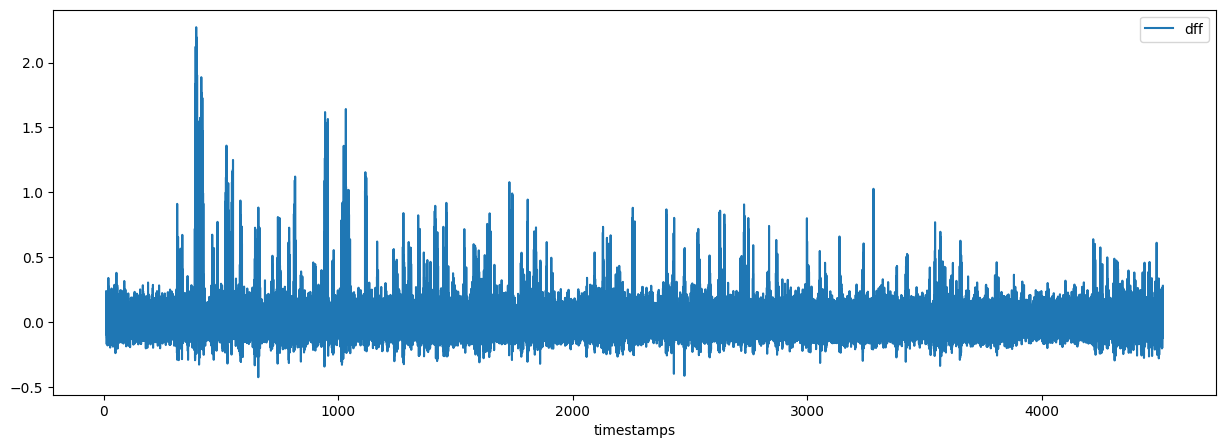

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
single_cell_timeseries.plot(
    x = 'timestamps',
    y = 'dff',
    ax = ax
)
fig.show()

# Load stimulus data into memory
The stimulus table is shared across all experiments (imaging planes) in a session. We can therefore use the stimulus table for just one experiment.

We are going to drop the `image_set` column because it is not informative for our purposes. We can then view the first 10 rows of the stimulus table.

In [ ]:
stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations
stimulus_table.head(10)

stimulus_block        stimulus_block_name  \
stimulus_presentations_id                                              
0                                       0   initial_gray_screen_5min   
1                                       1  change_detection_behavior   
2                                       1  change_detection_behavior   
3                                       1  change_detection_behavior   
4                                       1  change_detection_behavior   
5                                       1  change_detection_behavior   
6                                       1  change_detection_behavior   
7                                       1  change_detection_behavior   
8                                       1  change_detection_behavior   
9                                       1  change_detection_behavior   

                           image_index image_name  movie_frame_index  \
stimulus_presentations_id                                              
0                                  -99        NaN                -99   
1                                    0      im000                -99   
2                                    0      im000                -99   
3                                    0      im000                -99   
4                                    0      im000                -99   
5                                    0      im000                -99   
6                                    0      im000                -99   
7                                    0      im000                -99   
8                                    0      im000                -99   
9                                    0      im000                -99   

                             duration  start_time    end_time  start_frame  \
stimulus_presentations_id                                                    
0                          310.569786    0.000000  310.569786            0   
1                            0.250210  310.569786  310.819996        17985   
2                            0.250200  311.320396  311.570596        18030   
3                            0.250170  312.071016  312.321186        18075   
4                            0.250190  312.821616  313.071806        18120   
5                            0.250210  313.572196  313.822406        18165   
6                            0.250230  314.322816  314.573046        18210   
7                            0.250210  315.073456  315.323666        18255   
8                            0.250150  315.824126  316.074276        18300   
9                            0.250220  316.574676  316.824896        18345   

                           end_frame  is_change  is_image_novel  omitted  \
stimulus_presentations_id                                                  
0                              17985      False            <NA>     <NA>   
1                              18000      False           False    False   
2                              18045      False           False    False   
3                              18090      False           False    False   
4                              18135      False           False    False   
5                              18180      False           False    False   
6                              18225      False           False    False   
7                              18270      False           False    False   
8                              18315      False           False    False   
9                              18360      False           False    False   

                           movie_repeat  flashes_since_change  trials_id  \
stimulus_presentations_id                                                  
0                                   -99                     0        -99   
1                                   -99                     1          0   
2                                   -99                     2          0   
3                                   -99                     3      

This table provides helpful information like image name, start, duration and stop of image presentation, and whether the image was omitted. `stimulus_block` and `stimulus_block_name` indicate the type of stimulus mice were presented at a given point in a session. To select active change detection behavior, first we need to filter the table for `change_detection_behavior` or `1` block. Note that sessions may have different number of stimulus blocks, thus `change_detection_behavior` may be assosiated with either 0 or 1 in `stimulus_block` column.

In [ ]:
stimulus_table.stimulus_block_name.unique()

array(['initial_gray_screen_5min', 'change_detection_behavior',
       'post_behavior_gray_screen_5min', 'natural_movie_one'],
      dtype=object)

In [ ]:
stimulus_table = stimulus_table[stimulus_table.stimulus_block_name=='change_detection_behavior']
stimulus_table.reset_index(drop=True, inplace=True) # resetting index starts df at stimulus 0
# give index a name
stimulus_table.index.name = 'stimulus_presentations_id'
stimulus_table.head(5)

stimulus_block        stimulus_block_name  \
stimulus_presentations_id                                              
0                                       1  change_detection_behavior   
1                                       1  change_detection_behavior   
2                                       1  change_detection_behavior   
3                                       1  change_detection_behavior   
4                                       1  change_detection_behavior   

                           image_index image_name  movie_frame_index  \
stimulus_presentations_id                                              
0                                    0      im000                -99   
1                                    0      im000                -99   
2                                    0      im000                -99   
3                                    0      im000                -99   
4                                    0      im000                -99   

                           duration  start_time    end_time  start_frame  \
stimulus_presentations_id                                                  
0                           0.25021  310.569786  310.819996        17985   
1                           0.25020  311.320396  311.570596        18030   
2                           0.25017  312.071016  312.321186        18075   
3                           0.25019  312.821616  313.071806        18120   
4                           0.25021  313.572196  313.822406        18165   

                           end_frame  is_change  is_image_novel  omitted  \
stimulus_presentations_id                                                  
0                              18000      False           False    False   
1                              18045      False           False    False   
2                              18090      False           False    False   
3                              18135      False           False    False   
4                              18180      False           False    False   

                           movie_repeat  flashes_since_change  trials_id  \
stimulus_presentations_id                                                  
0                                   -99                     1          0   
1                                   -99                     2          0   
2                                   -99                     3          1   
3                                   -99                     4          1   
4                                   -99                     5          1   

                                                         stimulus_name  \
stimulus_presentations_id                                                
0                          Natural_Images_Lum_Matched_set_ophys_6_2017   
1                          Natural_Images_Lum_Matched_set_ophys_6_2017   
2                          Natural_Images_Lum_Matched_set_ophys_6_2017   
3                          Natural_Images_Lum_Matched_set_ophys_6_2017   
4                          Natural_Images_Lum_Matched_set_ophys_6_2017   

                           is_sham_change  active  
stimulus_presentations_id                          
0                                   False    True  
1                                   False    True  
2                                   False    True  
3                                   False    True  
4                                   False    True

## View the `stimulus_templates` attribute
Note that the `unwarped` column contains the image before the application of a spherical warp. All of the pixels labeled 'NaN' will be off-screen (not visible to the mouse) after the warp is applied.

All experiments in a given session will share the same `stimulus_templates`

In [ ]:
experiment = experiments[ophys_experiment_ids[0]]
experiment.stimulus_templates

unwarped  \
image_name                                                      
im000       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im106       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im075       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im073       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im045       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im054       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im031       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   
im035       [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...   

                                                       warped  
image_name                                                     
im000       [[122, 122, 123, 125, 126, 127, 128, 129, 130,...  
im106       [[108, 109, 106, 103, 102, 104, 107, 112, 117,...  
im075       [[120, 121, 121, 121, 122, 123, 123, 122, 121,...  
im073       [[120, 120, 118, 116, 116, 119, 121, 120, 117,...  
im045       [[10, 13, 6, 0, 0, 8, 15, 13, 6, 2, 4, 9, 12, ...  
im054       [[124, 125, 127, 130, 133, 134, 136, 138, 140,...  
im031       [[233, 234, 244, 253, 253, 244, 237, 239, 246,...  
im035       [[178, 181, 189, 198, 200, 198, 196, 199, 205,...

## View the unwarped images

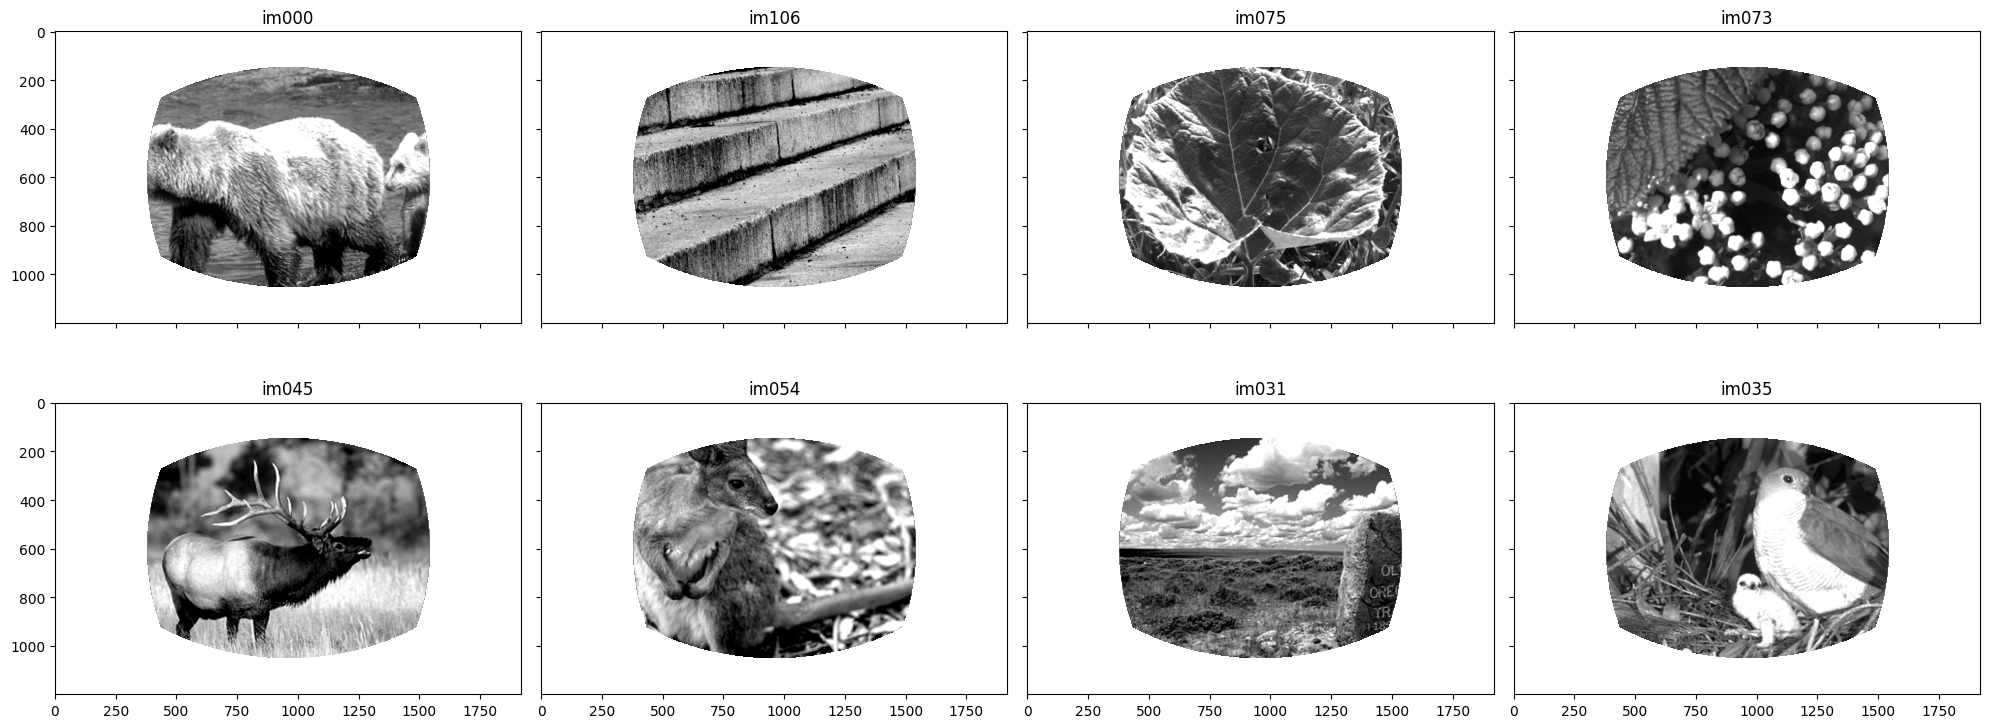

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
for ii, image_name in enumerate(experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(experiment.stimulus_templates.loc[image_name]['unwarped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()
fig.show()

## View the warped images
This represents what was actually on the screen during the session

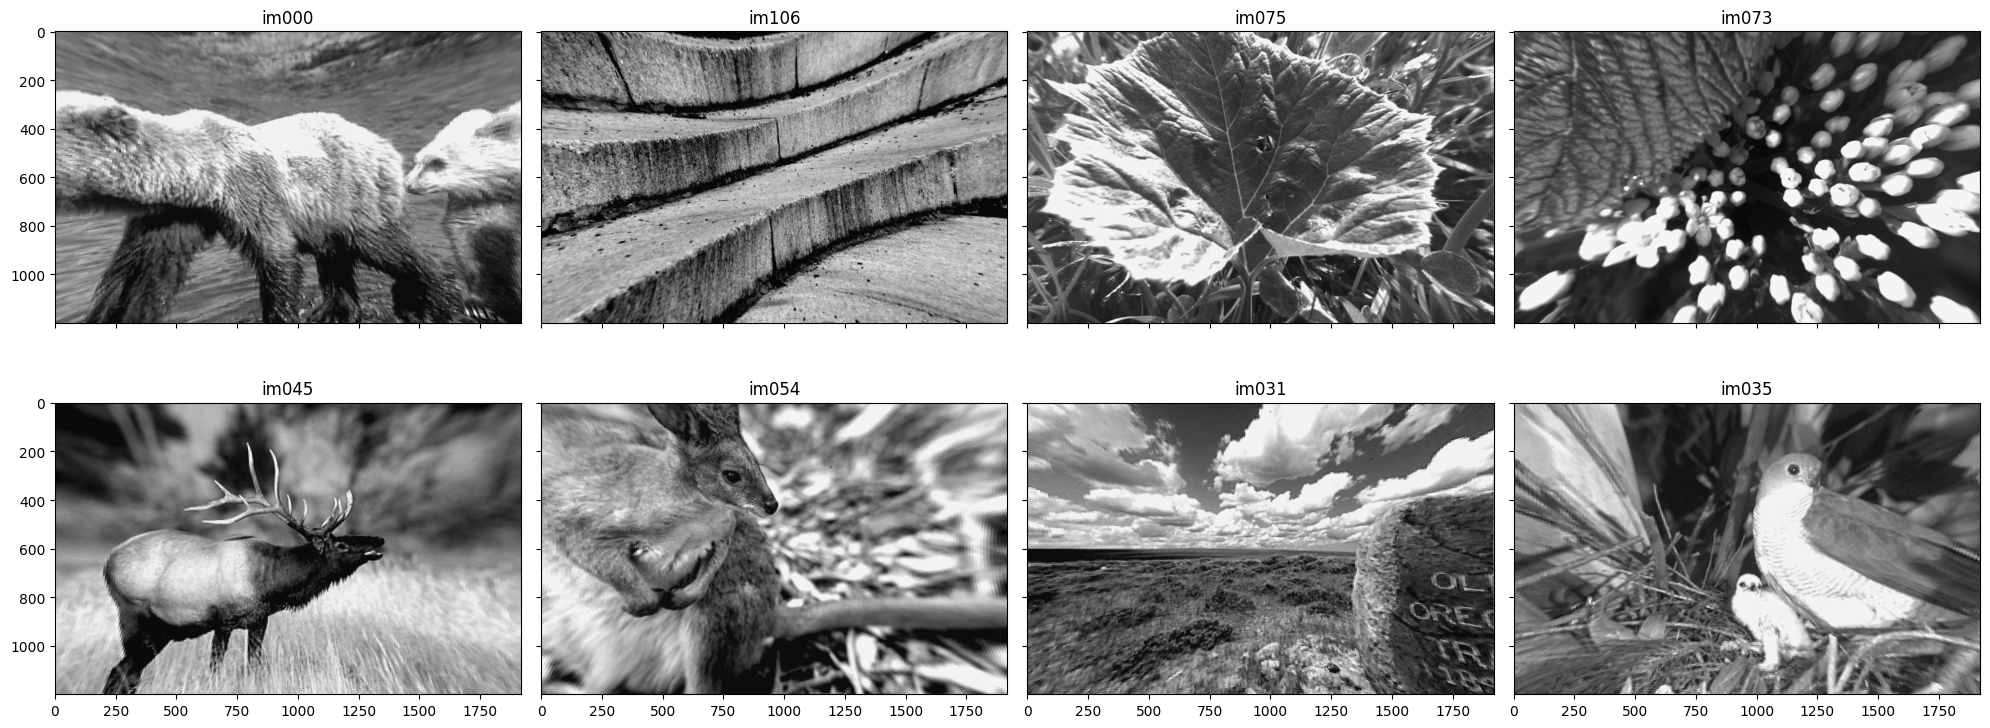

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
for ii, image_name in enumerate(experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(experiment.stimulus_templates.loc[image_name]['warped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()
fig.show()

## Describe stimulus omissions
An important feature of the task is that stimuli are shown at a very regular cadence (250 ms on, 500 ms off), but stimuli are randomly omitted with a probability of ~5%. These unexpected and random stimulus omissions could be perceived as an expectation violation by the mouse.

Omitted stimuli are denoted in the `stimulus_table` by the `omitted` column. `True` means that the stimulus that would have been shown at that time was actually omitted (and was replaced by an extended gray screen between stimuli).

We can look at the first 10 examples of omitted stimuli as follows. Note that each 'omitted' stimulus still has a 'start_time' and a 'stop_time' associated with it. This actually represents the time that a stimulus would have been shown, had it not been omitted.

Stimulus omissions are also indicated in the `image_name` column by the string `omitted`

In [ ]:
stimulus_table.query('omitted', engine='python').head(10)

stimulus_block        stimulus_block_name  \
stimulus_presentations_id                                              
61                                      1  change_detection_behavior   
105                                     1  change_detection_behavior   
113                                     1  change_detection_behavior   
128                                     1  change_detection_behavior   
143                                     1  change_detection_behavior   
172                                     1  change_detection_behavior   
174                                     1  change_detection_behavior   
243                                     1  change_detection_behavior   
254                                     1  change_detection_behavior   
267                                     1  change_detection_behavior   

                           image_index image_name  movie_frame_index  \
stimulus_presentations_id                                              
61                                   8    omitted                -99   
105                                  8    omitted                -99   
113                                  8    omitted                -99   
128                                  8    omitted                -99   
143                                  8    omitted                -99   
172                                  8    omitted                -99   
174                                  8    omitted                -99   
243                                  8    omitted                -99   
254                                  8    omitted                -99   
267                                  8    omitted                -99   

                           duration  start_time    end_time  start_frame  \
stimulus_presentations_id                                                  
61                             0.25  356.373816  356.623816        20731   
105                            0.25  389.400806  389.650806        22711   
113                            0.25  395.405686  395.655686        23071   
128                            0.25  406.664926  406.914926        23746   
143                            0.25  417.940786  418.190786        24422   
172                            0.25  439.708536  439.958536        25727   
174                            0.25  441.209796  441.459796        25817   
243                            0.25  493.018766  493.268766        28923   
254                            0.25  501.275466  501.525466        29418   
267                            0.25  511.033476  511.283476        30003   

                           end_frame  is_change  is_image_novel  omitted  \
stimulus_presentations_id                                                  
61                             20746      False            <NA>     True   
105                            22726      False            <NA>     True   
113                            23086      False            <NA>     True   
128                            23761      False            <NA>     True   
143                            24437      False            <NA>     True   
172                            25742      False            <NA>     True   
174                            25832      False            <NA>     True   
243                            28938      False            <NA>     True   
254                            29433      False            <NA>     True   
267                            30018      False            <NA>     True   

                           movie_repeat  flashes_since_change  trials_id  \
stimulus_presentations_id                                                  
61                                  -99                     2          7   
105                                 -99                     0         12   
113                                 -99                     7         13   
128                                 -99                    21         15   
143            

# Create an event triggered response dataframe relative to omissions
If we want to see how a given cell responds when regularly flashed stimuli are omitted, we can calculate the response around each of the stimulus omissions. The `brain_observatory_utilities` package has a convenience function to do this, in the module we imported as `utilities`. We give the function:
* a dataframe of interest (containing activity from one cell)
* the t and y values of interest
* the event times
* how much time before and after each event we are interested in
* the desired sampling rate of the output - this is the rate onto which the response will be interpolated

The function will return a new dataframe with the response for the given cell, aligned to each of the events.

In [ ]:
cell_id = cell_ids[11]
etr = utilities.event_triggered_response(
    data=neural_data.query('cell_specimen_id == @cell_id'),
    t='timestamps',
    y='dff',
    event_times=stimulus_table.query('omitted', engine='python')['start_time'],
    t_before=3,
    t_after=3,
    output_sampling_rate=50,
)
etr

time       dff  event_number  stimulus_presentations_id   event_time
0     -3.00  0.043293             0                         61   356.373816
1     -2.98  0.036577             0                         61   356.373816
2     -2.96  0.021164             0                         61   356.373816
3     -2.94  0.005752             0                         61   356.373816
4     -2.92 -0.009661             0                         61   356.373816
...     ...       ...           ...                        ...          ...
55680  2.92  0.001923           184                       4796  3911.326506
55681  2.94  0.001321           184                       4796  3911.326506
55682  2.96  0.001321           184                       4796  3911.326506
55683  2.98  0.001321           184                       4796  3911.326506
55684  3.00  0.001321           184                       4796  3911.326506

[55685 rows x 5 columns]

We can see that the output has colums for
* `time` - this is our new timebase relative to the events. In this case, it ranges from -3 to 3
* `dff` - this is the deltaF/F value surrounding each event, interpolated onto the new timebase. If, when calling the `event_triggered_response` function we had passed `y = 'events'`, this column would be events instead of dff.
* `event_number` - this is an integer representing the count of each event. In this example, there were 185 omissions, so they are numbered from 0 to 184
* `event_time` - this is the time of each event



The docstring for the `event_triggered_response` function can be viewed as follows:

In [ ]:
help(utilities.event_triggered_response)

Help on function event_triggered_response in module brain_observatory_utilities.utilities.general_utilities:

event_triggered_response(data, t, y, event_times, t_start=None, t_end=None, t_before=None, t_after=None, output_sampling_rate=None, include_endpoint=True, output_format='tidy', interpolate=True)
    Slices a timeseries relative to a given set of event times
    to build an event-triggered response.
    
    For example, If we have data such as a measurement of neural activity
    over time and specific events in time that we want to align
    the neural activity to, this function will extract segments of the neural
    timeseries in a specified time window around each event.
    
    The times of the events need not align with the measured
    times of the neural data.
    Relative times will be calculated by linear interpolation.
    
    Parameters:
    -----------
    data: Pandas.DataFrame
        Input dataframe in tidy format
        Each row should be one observation
   

## Plot an event triggered response

The output format of the `event_triggered_response` function is designed to plug directly into Seaborn's `lineplot` plotting function. We can then view the mean response to omitted stimuli with 95% confidence intervals very easily:

In [ ]:
sns.lineplot(
    data=etr,
    x='time',
    y='dff',
    n_boot=500
)

<Axes: xlabel='time', ylabel='dff'>

Note that the regular, image-driven responses with a 750 ms inter-stimulus interval are visible everywhere except at t=0, which is when the unexpectedly omitted stimulus occured.

### Make a function to plot an event triggered average in one line

If we make a wrapper function that combines the process of calculating and plotting the event triggered response, it can be called in a single line below. By having `event_query` input variable, we can use this function to plot responses to any event of interest (omisisons, changes, hits/misses, specific images, etc)

In [ ]:
def make_event_triggered_plot(df, x, y, event_query, ax, t_before=3, t_after=3):
    etr = utilities.event_triggered_response(
      data=df,
      t='timestamps',
      y=y,
      event_times=stimulus_table.query(event_query, engine='python')['start_time'],
      t_before=t_before,
      t_after=t_before,
      output_sampling_rate=50,
      )
    sns.lineplot(
      data=etr,
      x=x,
      y=y,
      n_boot=500,
      ax=ax
      )

Now plot the omission triggered response for the same cell using filtered events (these events extracted from the deltaF/F timeseries using an event extraction algorithm, then smoothed with a half-gaussian kernel) instead of dff.

In [ ]:
cell_id = cell_ids[11]
fig, ax = plt.subplots()
make_event_triggered_plot(
    df=neural_data.query('cell_specimen_id == @cell_id'),
    x='time',
    y='filtered_events',
    event_query='omitted',
    ax=ax
)
fig.show()

## Plot the responses for 10 sample cells
We can then iterate over 10 randomly chosen cells and plot their activity during omissions.

In [ ]:
np.random.seed(0)
fig, ax = plt.subplots()
for cell_id in tqdm(np.random.choice(cell_ids, size=10, replace=False)):
    make_event_triggered_plot(
      df=neural_data.query('cell_specimen_id == @cell_id'),
      x='time',
      y='dff',
      event_query='omitted',
      ax=ax
      )
fig.show()

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:26,  2.98s/it]

 20%|██        | 2/10 [00:05<00:23,  2.98s/it]

 30%|███       | 3/10 [00:08<00:20,  2.97s/it]

 40%|████      | 4/10 [00:11<00:17,  2.97s/it]

 50%|█████     | 5/10 [00:14<00:14,  2.98s/it]

 60%|██████    | 6/10 [00:17<00:11,  2.97s/it]

 70%|███████   | 7/10 [00:20<00:08,  2.96s/it]

 80%|████████  | 8/10 [00:23<00:05,  2.96s/it]

 90%|█████████ | 9/10 [00:26<00:02,  2.96s/it]

100%|██████████| 10/10 [00:29<00:00,  2.96s/it]

100%|██████████| 10/10 [00:29<00:00,  2.96s/it]

Interestingly, not all SST cells in this session do the same thing!

## Calculate the mean response for each of the individual imaging planes in this experiment
By iterating over experiment IDs, we can also calculate the mean response for each of the 6 imaging planes. Do Sst cells in different visual areas respond to omissions in a distinct way?

We will first use a Pandas `groupby` and `mean` operations to get the mean timeseries for each cell in that imaging plane:

In [ ]:
mean_dff_by_experiment = (
    neural_data
    .groupby(['ophys_experiment_id','timestamps'])['dff']
    .mean()
    .reset_index()
    )

In [ ]:
mean_dff_by_experiment.head()

ophys_experiment_id  timestamps       dff
0            854759890    10.52216  0.387612
1            854759890    10.61538  0.203569
2            854759890    10.70860  0.035257
3            854759890    10.80182  0.357586
4            854759890    10.89504  0.146397

We can then iterate over our 6 experiment IDs and use our `make_event_triggered_plot` wrapper function to calculate and plot the omission triggered response for that imaging plane:

In [ ]:
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

# iterate over every `ophys_experiment_id`
for ophys_experiment_id in tqdm(ophys_experiment_ids):
    make_event_triggered_plot(
      df=mean_dff_by_experiment.query('ophys_experiment_id == @ophys_experiment_id'),
      x='time',
      y='dff',
      event_query='omitted',
      ax=ax
      )

    # get some metadata to add to the legend
    this_exp = neural_data.query('ophys_experiment_id == @ophys_experiment_id')
    structure = this_exp['targeted_structure'].iloc[0]
    depth = this_exp['imaging_depth'].iloc[0]
    # append a string to our list of legend text
    legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))

# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1))
fig.show()

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:02<00:14,  2.99s/it]

 33%|███▎      | 2/6 [00:06<00:12,  3.01s/it]

 50%|█████     | 3/6 [00:08<00:08,  2.99s/it]

 67%|██████▋   | 4/6 [00:11<00:05,  2.99s/it]

 83%|████████▎ | 5/6 [00:14<00:02,  2.99s/it]

100%|██████████| 6/6 [00:17<00:00,  2.99s/it]

100%|██████████| 6/6 [00:17<00:00,  2.99s/it]

There are clearly some large differences in the way that Sst cells respond to these unexpected stimulus omissions by area.

This example could be extended to include cells from the other two cre-lines in the dataset: The VIP-Cre line which labels VIP+ inhibitory interneurons and the Slc17a7 line, which is a pan-excitatory line.

In [ ]:
session_table['cre_line'].unique()

array(['Sst-IRES-Cre', 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre'], dtype=object)

In addition, responses to different stimuli could be explored, along with responses relative to other behavioral measures, such as licking.

For a full description of the dataset and all available data streams, see the Visual Behavior Project Description at:
https://portal.brain-map.org/explore/circuits/visual-behavior-2p

# Set up data for scikit learn
What if we wanted to use scikit-learn for a decoding or clustering analysis? We'd need to get the data into a standard format for scikit learn, which is often a feature matrix (`X`) and a vector of labels (`y`).

Instead of just omissions, let's now look at the responses to each of the stimuli in this session, which consists of 8 unique images, plus the omitted stimuli (which we characterize as a unique stimulus type). First, we will calculate an event triggered response to each stimulus start time in the stimulus table.

In [ ]:
full_etr_l = []
# iterate over each unique cell
for cell_specimen_id in tqdm(neural_data['cell_specimen_id'].unique()):
  # calculate the event triggered response for this cell to every stimulus
  full_etr_this_cell = utilities.event_triggered_response(
      neural_data.query('cell_specimen_id == @cell_specimen_id'),
      t='timestamps',
      y='dff',
      event_times=stimulus_table['start_time'],
      t_before=0,
      t_after=0.75,
      output_sampling_rate=30
  )
  # add a column identifying the cell_specimen_id
  full_etr_this_cell['cell_specimen_id'] = cell_specimen_id
  # append to our list
  full_etr_l.append(full_etr_this_cell)

# concatenate our list of dataframes into a single dataframe
full_etr = pd.concat(full_etr_l)

# cast these numeric columns to int and float, respectively
full_etr['event_number'] = full_etr['event_number'].astype(int)
full_etr['event_time'] = full_etr['event_number'].astype(float)

# rename 'event_number' as
# full_etr.rename(columns={'event_number': 'stimulus_presentations_id'}, inplace=True)

  0%|          | 0/53 [00:00<?, ?it/s]

  2%|▏         | 1/53 [00:01<01:00,  1.16s/it]

  4%|▍         | 2/53 [00:02<00:54,  1.07s/it]

  6%|▌         | 3/53 [00:03<00:51,  1.04s/it]

  8%|▊         | 4/53 [00:04<00:52,  1.08s/it]

  9%|▉         | 5/53 [00:05<00:50,  1.05s/it]

 11%|█▏        | 6/53 [00:06<00:48,  1.03s/it]

 13%|█▎        | 7/53 [00:07<00:49,  1.07s/it]

 15%|█▌        | 8/53 [00:08<00:46,  1.04s/it]

 17%|█▋        | 9/53 [00:09<00:45,  1.03s/it]

 19%|█▉        | 10/53 [00:10<00:43,  1.02s/it]

 21%|██        | 11/53 [00:11<00:43,  1.05s/it]

 23%|██▎       | 12/53 [00:12<00:42,  1.03s/it]

 25%|██▍       | 13/53 [00:13<00:42,  1.07s/it]

 26%|██▋       | 14/53 [00:14<00:40,  1.04s/it]

 28%|██▊       | 15/53 [00:15<00:39,  1.03s/it]

 30%|███       | 16/53 [00:16<00:38,  1.03s/it]

 32%|███▏      | 17/53 [00:17<00:38,  1.07s/it]

 34%|███▍      | 18/53 [00:18<00:37,  1.07s/it]

 36%|███▌      | 19/53 [00:19<00:35,  1.04s/it]

 38%|███▊      | 20/53 [00:21<00:35,  1.07s/it]

 40%|███▉      | 21/53 [00:22<00:33,  1.06s/it]

 42%|████▏     | 22/53 [00:23<00:32,  1.05s/it]

 43%|████▎     | 23/53 [00:24<00:32,  1.07s/it]

 45%|████▌     | 24/53 [00:25<00:30,  1.05s/it]

 47%|████▋     | 25/53 [00:26<00:29,  1.04s/it]

 49%|████▉     | 26/53 [00:27<00:28,  1.06s/it]

 51%|█████     | 27/53 [00:28<00:27,  1.04s/it]

 53%|█████▎    | 28/53 [00:29<00:25,  1.03s/it]

 55%|█████▍    | 29/53 [00:30<00:25,  1.06s/it]

 57%|█████▋    | 30/53 [00:31<00:23,  1.04s/it]

 58%|█████▊    | 31/53 [00:32<00:22,  1.03s/it]

 60%|██████    | 32/53 [00:33<00:22,  1.06s/it]

 62%|██████▏   | 33/53 [00:34<00:20,  1.04s/it]

 64%|██████▍   | 34/53 [00:35<00:19,  1.03s/it]

 66%|██████▌   | 35/53 [00:36<00:18,  1.06s/it]

 68%|██████▊   | 36/53 [00:37<00:17,  1.04s/it]

 70%|██████▉   | 37/53 [00:38<00:16,  1.03s/it]

 72%|███████▏  | 38/53 [00:39<00:15,  1.05s/it]

 74%|███████▎  | 39/53 [00:40<00:14,  1.04s/it]

 75%|███████▌  | 40/53 [00:41<00:13,  1.03s/it]

 77%|███████▋  | 41/53 [00:42<00:12,  1.07s/it]

 79%|███████▉  | 42/53 [00:43<00:11,  1.05s/it]

 81%|████████  | 43/53 [00:45<00:10,  1.04s/it]

 83%|████████▎ | 44/53 [00:46<00:09,  1.07s/it]

 85%|████████▍ | 45/53 [00:47<00:08,  1.06s/it]

 87%|████████▋ | 46/53 [00:48<00:07,  1.05s/it]

 89%|████████▊ | 47/53 [00:49<00:06,  1.08s/it]

 91%|█████████ | 48/53 [00:50<00:05,  1.05s/it]

 92%|█████████▏| 49/53 [00:51<00:04,  1.04s/it]

 94%|█████████▍| 50/53 [00:52<00:03,  1.06s/it]

 96%|█████████▌| 51/53 [00:53<00:02,  1.05s/it]

 98%|█████████▊| 52/53 [00:54<00:01,  1.03s/it]

100%|██████████| 53/53 [00:55<00:00,  1.06s/it]

100%|██████████| 53/53 [00:55<00:00,  1.05s/it]

One way to construct a feature matrix might be to build it such that dimensions are `trials x cells`. Thus:

* Each row would be one trial, where a trial is defined as a unique image presentation
* Each column would represent the average response of a given cell on that image presentation.

To do so, let's construct another intermediate dataframe called `average_responses` that contains the average response of each cell (in the 750 ms window we've selected above) to each image presentation. We'll do this using a Pandas groupby to group by `cell_specimen_id` and `stimulus_presentations_id` (aka trial).

We're also going to merge in our stimulus metadata.

In [ ]:
full_etr['event_number'] = full_etr['event_number'].astype(int)
full_etr['event_time'] = full_etr['event_number'].astype(float)

In [ ]:
average_responses = full_etr.groupby(['cell_specimen_id', 'stimulus_presentations_id'])[['dff']].mean().reset_index().merge(
    stimulus_table,
    on='stimulus_presentations_id',
    how='left'
)
average_responses

cell_specimen_id  stimulus_presentations_id       dff  stimulus_block  \
0             1086547630                          0 -0.261392               1   
1             1086547630                          1  0.354413               1   
2             1086547630                          2  0.374132               1   
3             1086547630                          3  0.171823               1   
4             1086547630                          4 -0.065775               1   
...                  ...                        ...       ...             ...   
254607        1086560061                       4799 -0.007224               1   
254608        1086560061                       4800 -0.011908               1   
254609        1086560061                       4801  0.013366               1   
254610        1086560061                       4802 -0.022811               1   
254611        1086560061                       4803  0.029136               1   

              stimulus_block_name  image_index image_name  movie_frame_index  \
0       change_detection_behavior            0      im000                -99   
1       change_detection_behavior            0      im000                -99   
2       change_detection_behavior            0      im000                -99   
3       change_detection_behavior            0      im000                -99   
4       change_detection_behavior            0      im000                -99   
...                           ...          ...        ...                ...   
254607  change_detection_behavior            4      im045                -99   
254608  change_detection_behavior            4      im045                -99   
254609  change_detection_behavior            4      im045                -99   
254610  change_detection_behavior            4      im045                -99   
254611  change_detection_behavior            4      im045                -99   

        duration   start_time     end_time  start_frame  end_frame  is_change  \
0        0.25021   310.569786   310.819996        17985      18000      False   
1        0.25020   311.320396   311.570596        18030      18045      False   
2        0.25017   312.071016   312.321186        18075      18090      False   
3        0.25019   312.821616   313.071806        18120      18135      False   
4        0.25021   313.572196   313.822406        18165      18180      False   
...          ...          ...          ...          ...        ...        ...   
254607   0.25022  3913.578346  3913.828566       233989     234004      False   
254608   0.25018  3914.328936  3914.579116       234034     234049      False   
254609   0.25019  3915.079546  3915.329736       234079     234094      False   
254610   0.25023  3915.830156  3916.080386       234124     234139      False   
254611   0.25025  3916.580756  3916.831006       234169     234184      False   

        is_image_novel  omitted  movie_repeat  flashes_since_change  \
0                False    False           -99                     1   
1                False    False           -99                     2   
2                False    False           -99                     3   
3                False    False           -99                     4   
4                False    False           -99                     5   
...                ...      ...           ...                   ...   
254607           False    False           -99                     1   
254608           False    False           -99                     2   
254609           False    False           -99                     3   
254610           False    False           -99                     4   
254611           False    False           -99                     5   

        trials_id                                stimulus_name  \
0               0  Natural_Images_Lum_Matched_set_ophys_6_2017   
1               0  Natural_Images_Lum_Matched_set_ophys_6_2017   
2               1  Natural_Images_Lum_Matched_set_

Now we can construct a dataframe called `features_and_labels` that will contain one row per trial, one column per cell, plus columns with the image_index and image_name

In [ ]:
features_and_labels = average_responses.pivot(
    index='stimulus_presentations_id',
    columns='cell_specimen_id',
    values='dff'
).merge(
    stimulus_table[['image_index','image_name']],
    on='stimulus_presentations_id',
    how='left'
)
features_and_labels.sample(10)

1086547630  1086547796  1086547993  1086548072  \
stimulus_presentations_id                                                   
2802                         0.188744   -0.008572   -0.011187    0.068998   
873                          0.423262    0.195502    0.131998   -0.019266   
1428                        -0.031489   -0.021622   -0.084964    0.012929   
502                          0.352991    0.002643   -0.072307    0.006717   
831                         -0.112112    0.027243    0.119985   -0.082399   
142                         -0.213124   -0.011856   -0.066075    0.040839   
872                         -0.365919    0.128934    0.126414   -0.016161   
3561                        -0.265613   -0.023161   -0.047186    0.007225   
1894                         0.044039   -0.008075   -0.048363    0.012422   
4616                         0.565318   -0.023920   -0.008095    0.089502   

                           1086548118  1086548658  1086548969  1086549303  \
stimulus_presentations_id                                                   
2802                         0.004372    0.040266    0.000542    0.107748   
873                          0.038702    0.034431    0.002327   -0.057758   
1428                        -0.020635    0.020563   -0.093702   -0.077242   
502                          0.034363   -0.031389    0.041112    0.008856   
831                          0.026680    0.031627   -0.010097   -0.059420   
142                          0.020031    0.030649   -0.007731   -0.003524   
872                         -0.000917   -0.016184    0.180447    0.061008   
3561                        -0.004948   -0.013870   -0.023019   -0.175991   
1894                         0.041968    0.036341   -0.012176    0.021193   
4616                         0.007752    0.021257    0.016870    0.033922   

                           1086549491  1086549726  1086549813  1086549949  \
stimulus_presentations_id                                                   
2802                         0.027901    0.017652   -0.008583   -0.001325   
873                          0.037060    0.006215    0.091679    0.025424   
1428                         0.363789   -0.040719   -0.111365   -0.009501   
502                         -0.001766   -0.004686    0.041457    0.012696   
831                         -0.013806    0.011196    0.076926    0.006937   
142                          0.034375    0.007953   -0.005359    0.023818   
872                         -0.041748    0.003082   -0.080349    0.000304   
3561                         0.316958   -0.002102   -0.143713   -0.030722   
1894                        -0.019818   -0.000130    0.004117   -0.029039   
4616                        -0.050130    0.012862   -0.028429    0.018301   

                           1086550481  1086550544  1086550990  1086551114  \
stimulus_presentations_id                                                   
2802                         0.221544   -0.003638   -0.011980   -0.032854   
873                          0.053717    0.020017    0.047703    0.334743   
1428                         0.002781   -0.047153   -0.061137   -0.047434   
502                          0.012373   -0.012404    0.020623    1.669691   
831                          0.233008   -0.005911    0.006878   -0.024285   
142                          0.001401   -0.008858    0.015069    0.004903   
872                         -0.065836   -0.069230   -0.021769    2.336083   
3561                        -0.016735   -0.026546    0.006684    0.017497   
1894                        -0.025925    0.014631   -0.030741   -0.043443   
4616                         0.476721    0.014091    0.074191   -0.020188   

                           1086551151  1086551209  1086551301  1086551457  \
stimulus_presentations_id                                                   
2802                         0.025846    0.001994    0.114461    0.055439   
873                          0.044308    0.033760    0.012921    0.029380   
1428               

The X matrix can be extracted by getting the columns associated with the cell_specimen_ids

In [ ]:
X = features_and_labels[cell_ids]
X.sample(10)

1086550481  1086551114  1086551301  1086557083  \
stimulus_presentations_id                                                   
4189                         0.089903    0.024906   -0.046085   -0.034460   
250                          0.050824    0.041704   -0.001928    0.026821   
4348                         0.002091    0.021157   -0.052133    0.067661   
2791                         0.040069   -0.051707    0.522409    0.005746   
2275                        -0.041459    0.011008   -0.055237    0.047922   
3364                         0.001590    0.029114    0.042443    0.026074   
757                          0.112625    0.010699    0.073294    0.049768   
1231                         0.123487    0.012015    0.074686   -0.057958   
2861                         0.006513    0.032145    0.041042   -0.004228   
819                         -0.074397    4.207817   -0.056807   -0.002954   

                           1086557639  1086559064  1086558114  1086558224  \
stimulus_presentations_id                                                   
4189                         0.002261   -0.020595    0.071774   -0.002502   
250                          0.068230    0.004078   -0.005798    0.012790   
4348                         0.021547    0.105207    0.063571   -0.012539   
2791                        -0.036767    0.013612    0.007747    0.021827   
2275                         0.033297    0.022879    0.000088    0.003876   
3364                         0.015629    0.073447    0.041900   -0.013303   
757                         -0.023770    0.041888   -0.012735    0.001733   
1231                        -0.062489   -0.005719   -0.018863    0.001873   
2861                        -0.028449   -0.035138   -0.062131    0.024852   
819                          0.009688   -0.023455    0.033242    0.042787   

                           1086558510  1086559206  1086557304  1086557208  \
stimulus_presentations_id                                                   
4189                        -0.020789    0.001684    0.008464   -0.019575   
250                          0.056719   -0.004859   -0.030977   -0.032491   
4348                         0.688057    0.227734   -0.016318    0.085618   
2791                         0.220459    0.013104   -0.059429    0.006422   
2275                        -0.152558   -0.018586   -0.029864   -0.005584   
3364                         0.676601   -0.043063   -0.067287    0.030950   
757                         -0.090540    0.015469   -0.038199    0.041567   
1231                        -0.098702   -0.080393    0.000174   -0.011449   
2861                        -0.018202    0.017064    0.060212    0.023772   
819                          0.125576   -0.009704    0.022180    0.032723   

                           1086560061  1086559681  1086559885  1086559968  \
stimulus_presentations_id                                                   
4189                         0.049000   -0.035157   -0.003666   -0.015179   
250                          0.055306   -0.002700    0.011684   -0.014231   
4348                         0.022404   -0.013892   -0.001535    0.040991   
2791                         0.017736   -0.022348    0.024529    0.017214   
2275                         0.080266    0.015952    0.052953    0.304258   
3364                         0.020750    0.131443   -0.005691    0.051818   
757                         -0.045520    0.043685    0.033780    0.012523   
1231                         0.003779    0.140177   -0.085526   -0.002940   
2861                         0.017543   -0.024719   -0.037359   -0.009053   
819                         -0.005124   -0.047685   -0.042669   -0.060779   

                           1086557470  1086547796  1086547993  1086548118  \
stimulus_presentations_id                                                   
4189                        -0.107282   -0.024429    0.006634   -0.001652   
250                         -0.013565    0.157667   -0.002660    0.012759   
4348               

And `y` is just the `image_name` column (it could also be the `image_index` column if you want a numeric value instead of a string to represent the image identity)

In [ ]:
y = features_and_labels['image_name']
y.sample(10)

stimulus_presentations_id
3537    im073
2109    im000
34      im031
489     im106
4206    im106
3903    im054
1618    im035
1385    im106
4786    im106
2795    im054
Name: image_name, dtype: object

## Dimensionality reduction
Now we can use t-SNE, which will project our 53-dimensional feature space (53 neurons in the session) into two dimensions.

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(X.values)

And visualize the results, with colors representing each unique stimulus.

In [ ]:
features_and_labels['tsne-2d-one'] = X_embedded[:, 0]
features_and_labels['tsne-2d-two'] = X_embedded[:, 1]
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(
    data=features_and_labels,
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="image_name",
    hue_order=np.sort(features_and_labels['image_name'].unique()),
    palette=sns.color_palette()[:9],
    legend="full",
    alpha=0.3
)

This demonstrates that the time-averaged population responses to at least some of the stimuli seem to fall into distinct clusters in our 53-dimensional space, while others appear more overlapped. This implies that a decoding analysis might be more successful at decoding some stimuli than others.

## Train a simple decoder
We can use an SVM decoder from scikit learn to ask how well we can decode image identity from the feature matrix we have constructed.

Split our data into train and test sets, instantiate the model, then fit.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = svm.SVC(probability=True)
model.fit(X_train, y_train)

SVC(probability=True)

Use the model to make predictions on the held-out test set

In [ ]:
y_pred = model.predict(X_test)

Evaluate the accuracy

In [ ]:
accuracy_score(y_test, y_pred)

0.6216897856242118

Evaluate the confusion matrix

In [ ]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['predicted_{}'.format(im) for im in model.classes_],
    index=['actual_{}'.format(im) for im in model.classes_]
)

predicted_im000  predicted_im031  predicted_im035  \
actual_im000                 92                4               55   
actual_im031                 17               86               36   
actual_im035                  5               19              124   
actual_im045                  0               18                7   
actual_im054                 35                7               26   
actual_im073                  9               14               48   
actual_im075                  2                9               21   
actual_im106                  0                5                8   
actual_omitted                9               11                8   

                predicted_im045  predicted_im054  predicted_im073  \
actual_im000                  1               19               26   
actual_im031                  0                7               34   
actual_im035                  0                5               23   
actual_im045                161                0               14   
actual_im054                  0               94               24   
actual_im073                  0                4              100   
actual_im075                  0                2               35   
actual_im106                  0                1               10   
actual_omitted                1                6                6   

                predicted_im075  predicted_im106  predicted_omitted  
actual_im000                  0                0                  0  
actual_im031                  0                0                  2  
actual_im035                  0                2                  0  
actual_im045                  0                0                  1  
actual_im054                  0                0                  0  
actual_im073                  0                1                  0  
actual_im075                124                1                  0  
actual_im106                  1              194                  0  
actual_omitted                0                1                 11

This tells us that the model can decode some stimuli well (im035, im075 and im106, for example), while it struggles more with others (im000 and omissions, for example). Do the stimuli that the decoder succeeds in classifying align with those that cluster cleanly in t-SNE space?

### Follow up exercise

Can you create event triggered averages and perform decoding using other events of interest, such as licks or rewards?

In [ ]:
# Lick and reward data are available for each experiment
licks = experiments[ophys_experiment_id].licks
licks.head()

timestamps  frame
0    68.90307   3499
1    77.14313   3993
2    84.09879   4410
3    85.31647   4483
4    94.64071   5042

In [ ]:
rewards = experiments[ophys_experiment_id].rewards
rewards.head()

volume  timestamps  auto_rewarded
0   0.005   318.95740           True
1   0.005   328.69873           True
2   0.005   337.73943           True
3   0.005   354.25289           True
4   0.005   364.74479           True

To see the full list of all attributes available for each experiment via the AllenSDK, uncomment the cell below and run it

In [ ]:
# help(experiments[ophys_experiment_id])